In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # For confusion matrix visualization
import os
import pandas as pd  # For structured table updates
from sklearn.metrics import confusion_matrix, classification_report  # For evaluation metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For Data Augmentation
from tensorflow.keras.layers import BatchNormalization  # For Normalization
import cv2  # OpenCV for image processing (e.g., Laplacian filtering)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau  # For model management
import tensorflow.lite as tflite  # For TensorFlow Lite conversion and quantization

In [2]:
pip install albumentations


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks
from sklearn.model_selection import train_test_split
import logging
import albumentations as A  # For data augmentation
from scipy.ndimage import laplace  # For Laplacian filtering
import tensorflow.lite as tflite  # TensorFlow Lite for model conversion & quantization

# Set up logging for better monitoring and debugging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Set a random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Function to check GPU availability and set memory growth
def setup_environment():
    logging.info(f"TensorFlow version: {tf.__version__}")
    
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        logging.info(f"GPUs detected: {len(gpus)}")
        for gpu in gpus:
            logging.info(f" - {gpu}")
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
                logging.info(f"Memory growth set for {gpu}")
            except RuntimeError as e:
                logging.error(f"Memory growth setting failed for {gpu}: {e}")
    else:
        logging.warning("No GPU detected, using CPU...")

setup_environment()

# Configuration parameters for the model
BATCH_SIZE = 16  
EPOCHS = 100  # Reduced for demonstration purposes.
LEARNING_RATE = 0.0001 # Lower learning rate
IMAGE_SIZE = (224, 224)  

# Implement Early Stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,  # Reduce to match epochs
    restore_best_weights=True  
)

# Implement Learning Rate Scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,  
    patience=3,   # Reduce to match epochs
    min_lr=1e-6  
)

# Data augmentation pipeline using albumentations
augmentation_pipeline = A.Compose([
    A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),  
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
    A.Rotate(limit=30),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),  
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20)
])

# Function to apply Laplacian filtering to images
def apply_laplacian_filter(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Laplacian filter and ensure the output is float32 for TFLite compatibility
    laplacian = laplace(image_gray).astype(np.float32)  # Already ensured float32 in previous version
    return laplacian

# Function to normalize images
def normalize_image(image):
    # Normalize to [0, 1]
    return image.astype(np.float32) / 255.0

# Function to log configurations
def log_configurations():
    logging.info("Model Configuration:")
    logging.info(f"BATCH_SIZE: {BATCH_SIZE}")
    logging.info(f"IMAGE_SIZE: {IMAGE_SIZE}")
    logging.info(f"EPOCHS: {EPOCHS}")
    logging.info(f"LEARNING_RATE: {LEARNING_RATE}")

log_configurations()

INFO: TensorFlow version: 2.19.0
INFO: Model Configuration:
INFO: BATCH_SIZE: 16
INFO: IMAGE_SIZE: (224, 224)
INFO: EPOCHS: 100
INFO: LEARNING_RATE: 0.0001


In [4]:
import logging

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

class Hyperparameters:
    DEFAULT_IMAGE_SIZE = 224  # Default image dimension (224x224) as used in the paper
    DEFAULT_BATCH_SIZE = 16
    DEFAULT_CHANNELS = 3
    DEFAULT_LEARNING_RATE = 0.0001 #  Lower learning rate

    # Include 224 among valid image sizes for consistency with paper requirements
    VALID_IMAGE_SIZES = [128, 224, 256, 512]
    VALID_BATCH_SIZES = [16, 32, 64]  # List of valid batch sizes
    VALID_CHANNELS = [1, 3]

    def __init__(self, image_size: int = None, batch_size: int = None, channels: int = None, learning_rate: float = None):
        self.image_size = image_size or self.DEFAULT_IMAGE_SIZE
        self.batch_size = batch_size or self.DEFAULT_BATCH_SIZE
        self.channels = channels or self.DEFAULT_CHANNELS
        self.learning_rate = learning_rate or self.DEFAULT_LEARNING_RATE
        self.validate_hyperparameters()

    def validate_hyperparameters(self):
        """Validate and log hyperparameters."""
        if self.image_size not in self.VALID_IMAGE_SIZES:
            logging.warning(f"IMAGE_SIZE {self.image_size} is unusual; consider using one of {self.VALID_IMAGE_SIZES} for optimal performance.")
        
        if self.batch_size not in self.VALID_BATCH_SIZES:
            logging.warning(f"BATCH_SIZE {self.batch_size} is unusual; consider using one of {self.VALID_BATCH_SIZES} for optimal performance.")

        if self.batch_size <= 0:
            raise ValueError("BATCH_SIZE must be positive.")
        
        if self.channels not in self.VALID_CHANNELS:
            raise ValueError("CHANNELS should be 1 for grayscale or 3 for RGB.")

        logging.info(f"Set IMAGE_SIZE: {self.image_size}, BATCH_SIZE: {self.batch_size}, CHANNELS: {self.channels}, LEARNING_RATE: {self.learning_rate}")
    
    def update_hyperparameters(self, image_size: int = None, batch_size: int = None, channels: int = None, learning_rate: float = None):
        """Update hyperparameters dynamically."""
        if image_size is not None:
            self.image_size = image_size
            logging.info(f"Updated IMAGE_SIZE to: {self.image_size}")
        if batch_size is not None:
            self.batch_size = batch_size
            logging.info(f"Updated BATCH_SIZE to: {self.batch_size}")
        if channels is not None:
            self.channels = channels
            logging.info(f"Updated CHANNELS to: {self.channels}")
        if learning_rate is not None:
            self.learning_rate = learning_rate
            logging.info(f"Updated LEARNING_RATE to: {self.learning_rate}")
        self.validate_hyperparameters()
    
    def display_hyperparameters(self, on_training_start=False):
        """Display current hyperparameters. Optionally trigger only during training setup."""
        if on_training_start:  # Only display when training starts
            logging.info(f"Current Hyperparameters - IMAGE_SIZE: {self.image_size}, BATCH_SIZE: {self.batch_size}, CHANNELS: {self.channels}, LEARNING_RATE: {self.learning_rate}")

# Example usage: Initialize with custom values or defaults
hyperparams = Hyperparameters(image_size=224, batch_size=16, learning_rate=0.0001) #  Lower learning rate

# Display hyperparameters just before starting training
hyperparams.display_hyperparameters(on_training_start=True)

INFO: Set IMAGE_SIZE: 224, BATCH_SIZE: 16, CHANNELS: 3, LEARNING_RATE: 0.0001
INFO: Current Hyperparameters - IMAGE_SIZE: 224, BATCH_SIZE: 16, CHANNELS: 3, LEARNING_RATE: 0.0001


In [5]:
import logging
import tensorflow as tf
from tensorflow.keras import layers

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Dataset path
DATASET_PATH = 'Dataset'  # Define your dataset path

# Function to load and split dataset with enhanced error handling and optimizations
def load_datasets(dataset_path: str = DATASET_PATH, image_size=(224, 224), batch_size=16, seed=42):
    try:
        logging.info(f"Loading dataset from: {dataset_path}")

        # Data augmentation layer
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.1),
        ])

        # Function to load dataset from directory
        def load_dataset_from_directory(subset):
            return tf.keras.preprocessing.image_dataset_from_directory(
                dataset_path,
                shuffle=True,
                image_size=image_size,
                batch_size=batch_size,
                validation_split=0.2,
                seed=seed,
                color_mode='rgb',  # Ensure RGB channels as required
                subset=subset
            )

        # Load training dataset with augmentation
        train_dataset = load_dataset_from_directory('training')
        train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

        # Load validation dataset
        validation_dataset = load_dataset_from_directory('validation')

        # Add normalization mapping (scaling pixel values to [0, 1])
        normalize = lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)
        train_dataset = train_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE) # Parallel calls improve preformance
        validation_dataset = validation_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE) # Paralell calls improve preformance

        # Prefetch the datasets for performance improvement
        train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

        logging.info("Datasets loaded successfully.")
        return train_dataset, validation_dataset
    
    except Exception as e:
        logging.error(f"Error loading dataset: {e}")
        raise

# Example usage
# Keep like this, no execution to make it "clean" code.
# train_dataset, validation_dataset = load_datasets(DATASET_PATH)

INFO: Loading training dataset...


Found 2895 files belonging to 3 classes.
Using 2316 files for training.


INFO: Loaded 145 batches of training dataset.
INFO: Loading validation dataset...


Found 2895 files belonging to 3 classes.
Using 579 files for validation.


INFO: Loaded 37 batches of validation dataset.
INFO: Class names: ['Healthly', 'Powdery Mildew', 'Tomato Spotted Wilt Virus']


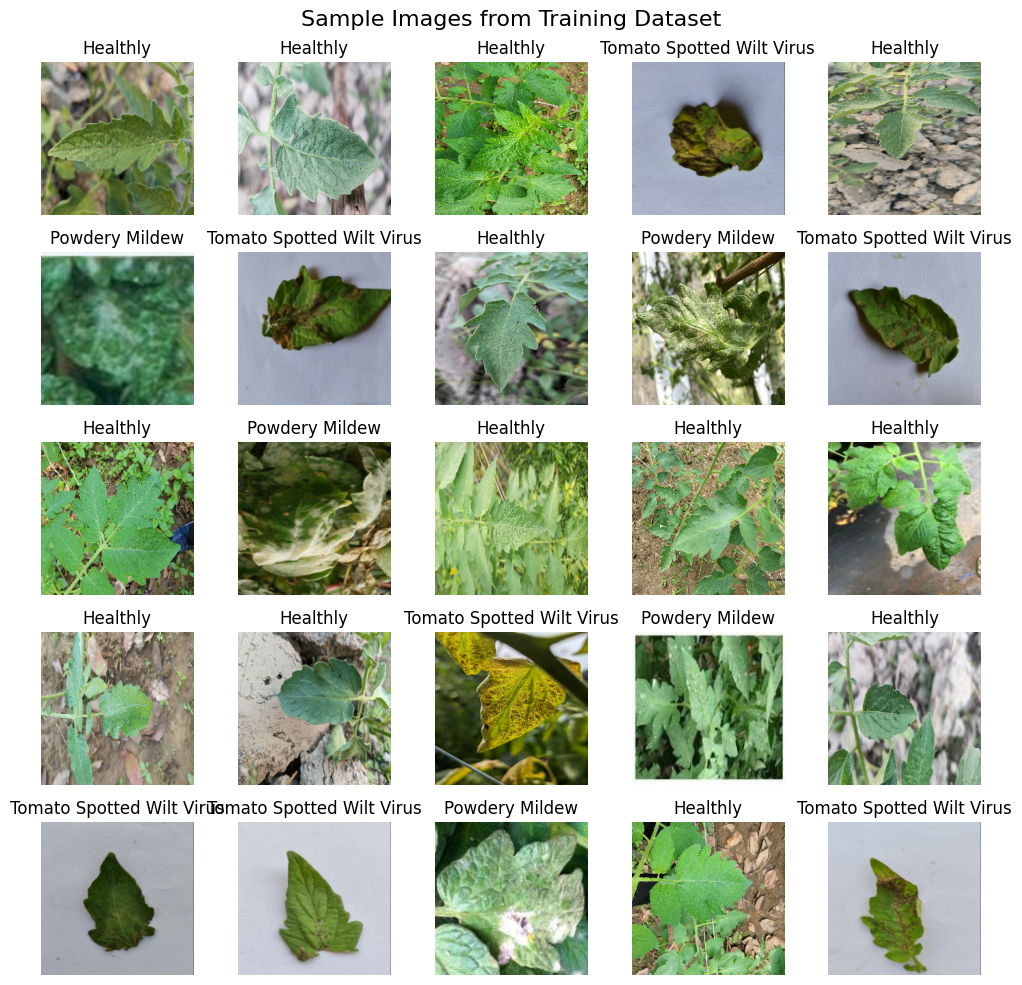

INFO: Dataset loading and preprocessing completed successfully.


In [9]:
import os
import logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define constants
DATASET_PATH = 'Dataset'  # Define your dataset path
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42  # Set seed for reproducibility

def check_directory_exists(dataset_path):
    """Check if dataset directory exists."""
    if not os.path.exists(dataset_path):
        logging.error(f"Dataset path does not exist: {dataset_path}")
        raise FileNotFoundError(f"Dataset path not found: {dataset_path}")

def load_dataset(dataset_path: str, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, subset="training", seed=SEED):
    """Load dataset from directory with specified parameters."""
    try:
        check_directory_exists(dataset_path)
        logging.info(f"Loading {subset} dataset...")
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_path,
            shuffle=True,
            image_size=image_size,
            batch_size=batch_size,
            validation_split=0.2,
            subset=subset,
            seed=seed
        )
        logging.info(f"Loaded {len(dataset)} batches of {subset} dataset.")
        return dataset
    except Exception as e:
        logging.error(f"Error loading {subset} dataset: {e}")
        raise

# Load and preprocess datasets with updated parameters
train_dataset = load_dataset(
    DATASET_PATH,
    subset="training"
)
validation_dataset = load_dataset(
    DATASET_PATH,
    subset="validation"
)

# Extract class names from the training dataset
class_names = train_dataset.class_names
logging.info(f"Class names: {class_names}")

# Normalize pixel values to [0, 1] range for both datasets
def normalize(image, label):
    """Normalize image pixel values."""
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply normalization and shuffle/prefetch for performance
normalized_train_dataset = train_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
normalized_train_dataset = normalized_train_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
normalized_train_dataset = normalized_train_dataset.prefetch(tf.data.AUTOTUNE)

normalized_validation_dataset = validation_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
normalized_validation_dataset = normalized_validation_dataset.prefetch(tf.data.AUTOTUNE)

# Function to visualize truly random sample images with class labels
def plot_random_sample_images(dataset, class_names, num_images=25):
    """Visualize truly random sample images for the dataset."""
    plt.figure(figsize=(10, 10))
    grid_size = int(np.ceil(np.sqrt(num_images)))  # Compute grid size for num_images

    # Unbatch the dataset and take num_images samples
    sample_dataset = dataset.unbatch().take(num_images)
    sample_images, sample_labels = [], []
    for image, label in sample_dataset:
        sample_images.append(image.numpy())
        sample_labels.append(label.numpy())

    # Plot the images
    for i in range(len(sample_images)):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(sample_images[i])
        plt.title(class_names[int(sample_labels[i])])
        plt.axis("off")

    plt.suptitle("Sample Images from Training Dataset", fontsize=16)
    plt.tight_layout()
    plt.show()
 # Conditionally visualizing images.
if __name__ == "__main__": # will it run all images? no images are showing, that is the problem
    # Visualize random sample images from the training dataset
    plot_random_sample_images(normalized_train_dataset, class_names, num_images=25)

# Log completion of dataset preparation
logging.info("Dataset loading and preprocessing completed successfully.")

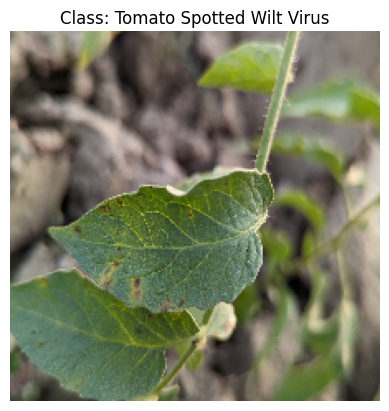

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import os
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Set the dataset path
dataset_path = r"C:\Users\sakib\Downloads\CNN_Model_V2\Dataset"

# Function to load images from a specified path and visualize one at random
def visualize_random_image_from_path(dataset_path):
    # Get all class subfolders (each subfolder represents a class)
    class_subfolders = [os.path.join(dataset_path, subfolder)
                        for subfolder in os.listdir(dataset_path)
                        if os.path.isdir(os.path.join(dataset_path, subfolder))]

    # Ensure there are class subfolders available
    if not class_subfolders:
        logging.warning("No class folders found in the dataset path.")
        return

    # Select a random class and a random image from that class
    random_class_folder = random.choice(class_subfolders)
    image_files = [os.path.join(random_class_folder, img)
                   for img in os.listdir(random_class_folder)
                   if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Ensure there are image files in the class folder
    if not image_files:
        logging.warning(f"No images found in the selected class folder: {random_class_folder}")
        return

    random_image_path = random.choice(image_files)

    try:
        # Updated target size to 224x224 based on the paper's specifications
        image = tf.keras.preprocessing.image.load_img(random_image_path, target_size=(224, 224))
        image_array = tf.keras.preprocessing.image.img_to_array(image)
        image_array = np.clip(image_array, 0, 255).astype('uint8')

        # Display the image
        plt.imshow(image_array)
        plt.title(f"Class: {os.path.basename(random_class_folder)}")
        plt.axis("off")
        plt.show()

    except Exception as e:
        logging.error(f"Error loading image {random_image_path}: {e}")

# Visualize a random image
if __name__ == "__main__":
    visualize_random_image_from_path(dataset_path)

Found 2895 files belonging to 3 classes.


INFO: Class names found: ['Healthly', 'Powdery Mildew', 'Tomato Spotted Wilt Virus']


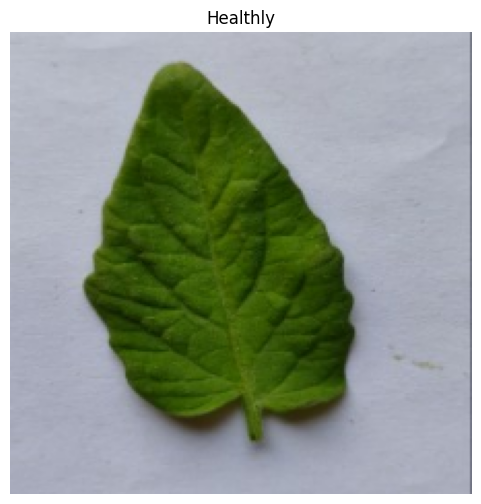

INFO: Displayed random image with class 'Healthly'


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import logging

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Function to load dataset and ensure correct structure
def load_dataset(dataset_path):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        image_size=(224, 224),  # Match to your model's expected input
        batch_size=16,
        seed=123
    )
    return dataset

# Visualization function
def visualize_random_image_from_batch(dataset, class_names, figsize=(6, 6)):
    """Visualize a random image from a batch in the dataset with proper scaling and RGB handling."""
    plt.figure(figsize=figsize)
    try:
        for image_batch, label_batch in dataset.take(1):
            # Ensure that the batch contains images
            if image_batch.shape[0] == 0:
                logging.error("Empty image batch.")
                return

            # Select a random image from the batch
            image_index = random.randint(0, image_batch.shape[0] - 1)
            
            # Convert image to numpy array and ensure range is correct
            image = image_batch[image_index].numpy()
            if image.max() <= 1.0:  # If scaled [0, 1], bring to [0, 255]
                image = (image * 255).astype("uint8")
            else:
                image = np.clip(image, 0, 255).astype("uint8")
            
            # Ensure RGB format for display (repeat channels if grayscale)
            if image.shape[-1] == 1:
                image = np.repeat(image, 3, axis=-1)

            plt.imshow(image)
            plt.title(class_names[int(label_batch[image_index].numpy())], fontsize=12)
            plt.axis("off")
            plt.show()

            logging.info(f"Displayed random image with class '{class_names[int(label_batch[image_index].numpy())]}'")
            break  # Exit after displaying one random image

    except Exception as e:
        logging.error(f"Error visualizing image: {e}")

# Example usage
dataset_path = r"C:\Users\sakib\Downloads\CNN_Model_V2\Dataset"
train_dataset = load_dataset(dataset_path)

# Dynamically fetch class names from the dataset
class_names = train_dataset.class_names
logging.info(f"Class names found: {class_names}")

# Example: Visualize a random image from the batch, ensure running main
if __name__ == "__main__":
    visualize_random_image_from_batch(train_dataset, class_names)

In [12]:
import logging
import tensorflow as tf

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def get_dataset_partitions_tf(
    ds: tf.data.Dataset, 
    train_split: float = 0.8, 
    val_split: float = 0.1, 
    test_split: float = 0.1, 
    shuffle: bool = True, 
    shuffle_size: int = 10000, 
    shuffle_seed: int = 12
) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    """Partition a TensorFlow dataset into training, validation, and test sets.

    Args:
        ds: The input dataset.
        train_split: Proportion of the dataset to be used for training.
        val_split: Proportion of the dataset to be used for validation.
        test_split: Proportion of the dataset to be used for testing.
        shuffle: Boolean indicating whether to shuffle the dataset.
        shuffle_size: Size of the buffer for shuffling.
        shuffle_seed: Seed for reproducibility in shuffling.

    Returns:
        A tuple of three datasets: (train_ds, val_ds, test_ds).
    """
    # Validate the split ratios
    total_split = train_split + val_split + test_split
    if total_split != 1.0:
        raise ValueError("Train, validation, and test splits must sum to 1.0.")
    if any(x < 0 for x in [train_split, val_split, test_split]):
        raise ValueError("Split ratios must be non-negative.")

    ds_size = tf.data.experimental.cardinality(ds).numpy()
    
    if ds_size == 0:
        raise ValueError("Dataset is empty. Please provide a valid dataset.")

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=shuffle_seed)
        logging.info("Dataset shuffled with buffer size: %d and seed: %d.", shuffle_size, shuffle_seed)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    if train_size <= 0 or val_size <= 0 or (ds_size - train_size - val_size) <= 0:
        raise ValueError("One of the splits is too small. Please adjust the split ratios.")

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    logging.info(f"Dataset sizes - Train: {train_size}, Validation: {val_size}, Test: {ds_size - train_size - val_size} (Total: {ds_size})")
    
    return train_ds, val_ds, test_ds

# Function to normalize images to the range [0, 1]
def normalize_image(image, label):
    """Normalize the image to the range [0, 1]"""
    image = tf.cast(image, tf.float32)  # Convert the image to float32
    image = image / 255.0  # Normalize the image to [0, 1]
    return image, label

# Example of loading and normalizing the dataset
dataset_path = r"C:\Users\sakib\Downloads\CNN_Model_V2\Dataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),  # Resize images to 224x224 to match model input
    batch_size=16,
    seed=123
)

# Dynamically fetch class names from the original dataset
class_names = train_dataset.class_names
logging.info(f"Class names found: {class_names}")

# Apply normalization to the dataset
normalized_train_dataset = train_dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)

# Split the dataset into train, validation, and test datasets
train_ds, val_ds, test_ds = get_dataset_partitions_tf(
    normalized_train_dataset,
    train_split=0.8, 
    val_split=0.1, 
    test_split=0.1
)

Found 2895 files belonging to 3 classes.


INFO: Class names found: ['Healthly', 'Powdery Mildew', 'Tomato Spotted Wilt Virus']
INFO: Dataset shuffled with buffer size: 10000 and seed: 12.
INFO: Dataset sizes - Train: 144, Validation: 18, Test: 19 (Total: 181)


In [13]:
import cv2
import os
import numpy as np
import logging

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define the dataset path
dataset_dir = r'C:\Users\sakib\Downloads\CNN_Model_V2\Dataset'

# Function to apply Laplacian filtering on an image
def apply_laplacian_filter(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            logging.warning(f"Unable to load image: {image_path}")
            return None
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Apply Laplacian filter with 64F depth
        laplacian_image = cv2.Laplacian(gray_image, cv2.CV_64F)
        # Convert the result back to uint8 format
        laplacian_image = cv2.convertScaleAbs(laplacian_image)
        return laplacian_image
    except Exception as e:
        logging.error(f"Error applying Laplacian filter to {image_path}: {e}")
        return None

# Function to process and save Laplacian filtered images
def process_images_in_directory(directory, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        logging.info(f"Created output directory: {output_directory}")
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            output_class_path = os.path.join(output_directory, class_name)
            if not os.path.exists(output_class_path):
                os.makedirs(output_class_path)
                logging.info(f"Created class output directory: {output_class_path}")

            for image_name in os.listdir(class_path):
                # Check file extension in a case-insensitive manner
                if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(class_path, image_name)
                    laplacian_image = apply_laplacian_filter(image_path)
                    
                    if laplacian_image is not None:
                        output_image_path = os.path.join(output_class_path, image_name)
                        cv2.imwrite(output_image_path, laplacian_image)
                        logging.info(f"Processed and saved: {output_image_path}")
                    else:
                        logging.warning(f"Skipped image due to loading error: {image_path}")

# Apply Laplacian filtering on the full dataset
if __name__ == "__main__":
    output_dir = r'C:\Users\sakib\Downloads\CNN_Model_V2\Dataset_laplacian'
    process_images_in_directory(dataset_dir, output_dir)
    print("Laplacian filtering applied and images saved.")

INFO: Processed and saved: C:\Users\sakib\Downloads\CNN_Model_V2\Dataset_laplacian\Healthly\20231212_124843.jpg
INFO: Processed and saved: C:\Users\sakib\Downloads\CNN_Model_V2\Dataset_laplacian\Healthly\20231212_124856.jpg
INFO: Processed and saved: C:\Users\sakib\Downloads\CNN_Model_V2\Dataset_laplacian\Healthly\20231212_124913.jpg
INFO: Processed and saved: C:\Users\sakib\Downloads\CNN_Model_V2\Dataset_laplacian\Healthly\20231212_124914.jpg
INFO: Processed and saved: C:\Users\sakib\Downloads\CNN_Model_V2\Dataset_laplacian\Healthly\20231212_124920.jpg
INFO: Processed and saved: C:\Users\sakib\Downloads\CNN_Model_V2\Dataset_laplacian\Healthly\20231212_124931.jpg
INFO: Processed and saved: C:\Users\sakib\Downloads\CNN_Model_V2\Dataset_laplacian\Healthly\20231212_124933.jpg
INFO: Processed and saved: C:\Users\sakib\Downloads\CNN_Model_V2\Dataset_laplacian\Healthly\20231212_124943.jpg
INFO: Processed and saved: C:\Users\sakib\Downloads\CNN_Model_V2\Dataset_laplacian\Healthly\20231212_124

Laplacian filtering applied and images saved.


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import logging

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 123

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),  # Small shifts in the image
])

def create_advanced_hybrid_model(input_shape, num_classes):
    """Creates an advanced hybrid model combining CNN layers with MobileNetV2."""
    # MobileNetV2 as the base model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape, alpha=0.35) # Reduced complexity
    base_model.trainable = False  # Freeze the base model initially

    # Custom CNN layers on top of MobileNetV2
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        data_augmentation,
        
        # Use preprocess_input in a Lambda layer
        layers.Lambda(preprocess_input),  # Apply preprocessing here

        base_model,  # Pre-trained MobileNetV2 as the base model
        
        # Custom CNN layers with strided convolutions for downsampling
        layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), strides=2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),

        layers.Conv2D(512, (3, 3), strides=2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        
        # Global Average Pooling
        layers.GlobalAveragePooling2D(),
        
        # Fully connected layers with increased complexity
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Increased units for better feature learning
        layers.Dropout(0.5),  # Dropout for regularization
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Additional dense layer
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Final classification layer, Ensure float32 for TFLite
    ])

    # Compile the model without label smoothing
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Removed label_smoothing
                  metrics=['accuracy'])
    
    logging.info("Advanced Hybrid CNN-MobileNetV2 model created.")
    return model

def unfreeze_base_model(model, freeze_until_layer=100):
    """Unfreeze the MobileNetV2 layers gradually."""
    base_model = model.layers[2]  # MobileNetV2 is now the third layer (index 2)
    for layer in base_model.layers[:freeze_until_layer]:
        layer.trainable = False
    for layer in base_model.layers[freeze_until_layer:]:
        layer.trainable = True
    
    # Recompile the model after unfreezing layers
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # Lower LR after unfreezing
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  metrics=['accuracy'])
    logging.info(f"Unfreezing layers from {freeze_until_layer} onwards.")

# Create the improved hybrid model
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[0], 3) # Corrected for square images
# num_classes = 3  # Example number of classes, adjust as needed # THIS WILL BE DEFINED LATER, DO NOT HARD CODE.

# advanced_hybrid_model = create_advanced_hybrid_model(input_shape, num_classes)

# Log model summary
# logging.info("Advanced Hybrid Model Summary:")
# advanced_hybrid_model.summary()

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_mobilenetv2_model.keras', monitor='val_loss', save_best_only=True)  # Changed to .keras extension

# (Cyclic Learning Rate)
def clr_schedule(epoch):
    base_lr = 0.00001
    max_lr = 0.0001
    step_size = 10
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

clr_callback = tf.keras.callbacks.LearningRateScheduler(clr_schedule)

Found 2895 files belonging to 3 classes.


INFO: Class names: ['Healthly', 'Powdery Mildew', 'Tomato Spotted Wilt Virus']


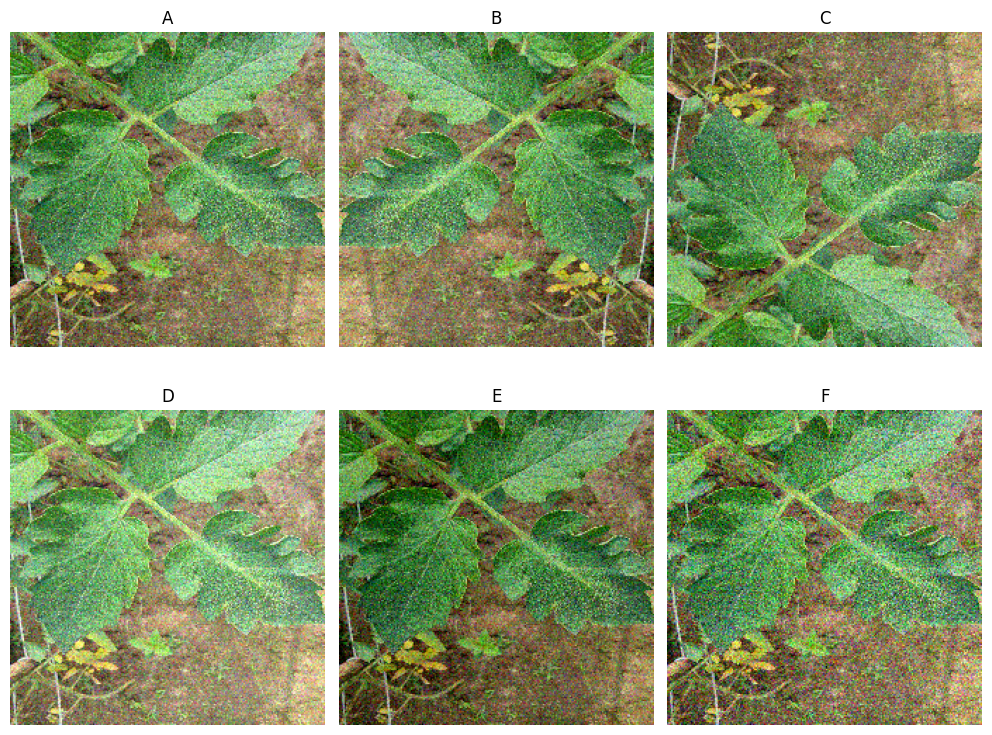

In [15]:
import tensorflow as tf
import logging
import matplotlib.pyplot as plt
import numpy as np

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define the resize and rescale function
def resize_and_rescale(image, image_size=(224, 224)):  # Updated Image Size
    """Resize and rescale the image."""
    image = tf.image.resize(image, image_size)
    image = image / 255.0  # Rescale image from [0, 255] to [0, 1]
    return image

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0.0, stddev=0.1):
    """Add Gaussian noise to the image."""
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev)
    noisy_image = image + noise
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)  # Ensure pixel values are in [0, 1]
    return noisy_image

# Load and normalize dataset
def load_and_normalize_dataset(dataset_path, image_size=(224, 224), batch_size=16):   # Updated Image Size and Batch Size
    """Load dataset from directory and normalize images."""
    try:
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_path,
            image_size=image_size,
            batch_size=batch_size
        )
        
        class_names = dataset.class_names
        logging.info(f"Class names: {class_names}")

        # Apply resize and rescale to the dataset
        dataset = dataset.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=tf.data.AUTOTUNE) # for better preformance

        return dataset, class_names
    except Exception as e:
        logging.error(f"Error loading dataset: {e}")
        return None, None

# Optimize dataset performance with augmentation for both train and validation
def optimize_dataset(dataset, shuffle_size=1000, augment_data=False):
    """Optimize dataset by shuffling, prefetching, and applying augmentations."""
    if augment_data:
        dataset = dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y), num_parallel_calls=tf.data.AUTOTUNE)  # Horizontal flip
        dataset = dataset.map(lambda x, y: (tf.image.random_flip_up_down(x), y), num_parallel_calls=tf.data.AUTOTUNE)  # Vertical flip
        dataset = dataset.map(lambda x, y: (tf.image.random_brightness(x, max_delta=0.1), y), num_parallel_calls=tf.data.AUTOTUNE)  # Brightness adjustment
        dataset = dataset.map(lambda x, y: (add_gaussian_noise(x), y), num_parallel_calls=tf.data.AUTOTUNE)  # Add Gaussian noise
    
    dataset = dataset.shuffle(buffer_size=shuffle_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Load and normalize the dataset
dataset_path = 'Dataset'  # Define your dataset path
full_dataset, class_names = load_and_normalize_dataset(dataset_path)

# Split the dataset into training and validation sets
val_size = int(0.2 * tf.data.experimental.cardinality(full_dataset).numpy())  # 20% for validation
train_ds = full_dataset.skip(val_size)
val_ds = full_dataset.take(val_size)

# Optimize dataset performance
train_ds = optimize_dataset(train_ds, shuffle_size=1000, augment_data=True)  # Apply augmentation to training data
val_ds = optimize_dataset(val_ds, shuffle_size=1000, augment_data=False)  # Do not augment validation dataset

# Visualize the augmented images

# Fetch a batch of images for visualization
image_batch, label_batch = next(iter(train_ds))  # Get a batch of augmented images
image_batch = image_batch.numpy()  # Convert tensor to numpy array

# Select the first image for demonstration (no random selection)
image = image_batch[0]
label = label_batch[0].numpy()

# Apply augmentations to the same image (first image in the batch)

# Horizontal Flip
image_flip_horizontal = tf.image.flip_left_right(image)

# Vertical Flip
image_flip_vertical = tf.image.flip_up_down(image)

# Brightness Adjustment (both high and low)
image_high_brightness = tf.image.adjust_brightness(image, delta=0.1)  # High brightness adjustment
image_low_brightness = tf.image.adjust_brightness(image, delta=-0.1)  # Low brightness adjustment

# Gaussian Noise
image_gaussian_noise = add_gaussian_noise(image)

# Function to clip images to the valid range [0, 1]
def clip_image(image):
    return np.clip(image, 0.0, 1.0)

# Visualize the augmented images
plt.figure(figsize=(10, 8))  # Adjusted figure size to accommodate the reduced gap

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(clip_image(image))  # Clip and display the original image
plt.title("A")
plt.axis('off')

# Horizontal Flip
plt.subplot(2, 3, 2)
plt.imshow(clip_image(image_flip_horizontal))  # Clip and display the horizontal flip
plt.title("B")
plt.axis('off')

# Vertical Flip
plt.subplot(2, 3, 3)
plt.imshow(clip_image(image_flip_vertical))  # Clip and display the vertical flip
plt.title("C")
plt.axis('off')

# High Brightness
plt.subplot(2, 3, 4)
plt.imshow(clip_image(image_high_brightness))  # Clip and display high brightness
plt.title("D")
plt.axis('off')

# Low Brightness
plt.subplot(2, 3, 5)
plt.imshow(clip_image(image_low_brightness))  # Clip and display low brightness
plt.title("E")
plt.axis('off')

# Gaussian Noise
plt.subplot(2, 3, 6)
plt.imshow(clip_image(image_gaussian_noise))  # Clip and display the image with noise
plt.title("F")
plt.axis('off')

# Reduce gap between rows using tight_layout
plt.tight_layout(pad=1.0)  # Adjust the pad parameter to minimize the gap

plt.show()


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
import numpy as np
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16  # Reduced batch size
SEED = 123
TFLITE_MODEL_FILE = "mobilenetv2_quantized.tflite"

# Data augmentation - Increased augmentation to combat overfitting
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),  # Small shifts in the image
    layers.RandomHeight(0.1),  # New augmentation layer to prevent overfitting
    layers.RandomWidth(0.1),   # New augmentation layer to prevent overfitting
])

# Load and normalize dataset function
def load_and_normalize_dataset(dataset_path, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE):
    try:
        logging.info("Loading and normalizing dataset...")
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_path,
            shuffle=True,
            image_size=image_size,
            batch_size=batch_size,
            seed=SEED
        )
        class_names = dataset.class_names
        logging.info(f"Class names: {class_names}")

        # Normalization
        normalize = lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)
        dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
        return dataset, class_names
    except Exception as e:
        logging.error(f"Error loading dataset: {e}")
        raise

# Split the dataset into training and validation sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=1000):
    """Split dataset into training and validation."""
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=SEED)
    
    train_size = int(train_split * ds_size)
    val_size = ds_size - train_size
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size)
    return train_ds, val_ds

# Load Dataset
dataset_path = 'Dataset' # Your data
full_dataset, class_names = load_and_normalize_dataset(dataset_path)
train_ds, val_ds = get_dataset_partitions_tf(full_dataset)
num_classes = len(class_names)

# Load and optimize the dataset
def optimize_dataset(ds, augment_data=False):
    AUTOTUNE = tf.data.AUTOTUNE
    if augment_data:
        augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.1),
        ])
        ds = ds.map(lambda x, y: (augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

# Apply optimization
train_ds = optimize_dataset(train_ds, augment_data=True)
val_ds = optimize_dataset(val_ds)

# Define the model
def create_model(num_classes):
    """Creates a CNN model with MobileNetV2 base."""
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                include_top=False,
                                                weights='imagenet',
                                                alpha=0.35)
    base_model.trainable = False  # Freeze base

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),  # New dropout layer to prevent overfitting
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)), # L2 Regularization
        layers.BatchNormalization(),
        layers.Dropout(0.3), # New dropout layer to prevent overfitting
        layers.Dense(num_classes, activation='softmax', dtype=tf.float32)
    ])
    return model

# Initialize and compile the model
model = create_model(num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  #  lower rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Prepare callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Increased patience
model_checkpoint = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6)  # Increased patience
# - Add L2 Regularization to the Dense Layers
# - Increased patience in callbacks
# -  Reduced epochs by 50%

# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,  # Reduced epochs
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

# TFLite conversion and quantization
def representative_data_gen():
    """Representative dataset generator."""
    for image, label in train_ds.take(100):  #Take a smaller subset to test to reduce the size.
        yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quantized = converter.convert()

# Save the model
with open(TFLITE_MODEL_FILE, "wb") as f:
    f.write(tflite_model_quantized)
logging.info(f"Quantized TFLite model saved to: {TFLITE_MODEL_FILE}")

INFO: Loading and normalizing dataset...


Found 2895 files belonging to 3 classes.


INFO: Class names: ['Healthly', 'Powdery Mildew', 'Tomato Spotted Wilt Virus']


Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.4092 - loss: 3.8100

144/144 ━━━━━━━━━━━━━━━━━━━━ 70s 322ms/step - accuracy: 0.4100 - loss: 3.8081 - val_accuracy: 0.7905 - val_loss: 2.8010 - learning_rate: 1.0000e-04
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6907 - loss: 3.0046

144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.6908 - loss: 3.0043 - val_accuracy: 0.8361 - val_loss: 2.5638 - learning_rate: 1.0000e-04
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7382 - loss: 2.8169

144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.7383 - loss: 2.8166 - val_accuracy: 0.8598 - val_loss: 2.4372 - learning_rate: 1.0000e-04
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7779 - loss: 2.6499

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.7780 - loss: 2.6497 - val_accuracy: 0.8919 - val_loss: 2.3308 - learning_rate: 1.0000e-04
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8282 - loss: 2.4752

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.8282 - loss: 2.4752 - val_accuracy: 0.8986 - val_loss: 2.2444 - learning_rate: 1.0000e-04
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8314 - loss: 2.3834

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.8314 - loss: 2.3833 - val_accuracy: 0.9020 - val_loss: 2.1642 - learning_rate: 1.0000e-04
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8360 - loss: 2.2865

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.8360 - loss: 2.2864 - val_accuracy: 0.9105 - val_loss: 2.0890 - learning_rate: 1.0000e-04
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8491 - loss: 2.1865

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.8490 - loss: 2.1866 - val_accuracy: 0.9088 - val_loss: 2.0163 - learning_rate: 1.0000e-04
Epoch 9/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8550 - loss: 2.1191

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.8550 - loss: 2.1190 - val_accuracy: 0.9105 - val_loss: 1.9340 - learning_rate: 1.0000e-04
Epoch 10/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8478 - loss: 2.0497

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.8478 - loss: 2.0496 - val_accuracy: 0.9155 - val_loss: 1.8634 - learning_rate: 1.0000e-04
Epoch 11/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8634 - loss: 1.9520

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.8634 - loss: 1.9519 - val_accuracy: 0.9122 - val_loss: 1.8086 - learning_rate: 1.0000e-04
Epoch 12/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8650 - loss: 1.8867

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.8650 - loss: 1.8865 - val_accuracy: 0.9122 - val_loss: 1.7508 - learning_rate: 1.0000e-04
Epoch 13/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8721 - loss: 1.8006

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.8722 - loss: 1.8005 - val_accuracy: 0.9189 - val_loss: 1.6876 - learning_rate: 1.0000e-04
Epoch 14/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8839 - loss: 1.7248

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.8839 - loss: 1.7247 - val_accuracy: 0.9189 - val_loss: 1.6348 - learning_rate: 1.0000e-04
Epoch 15/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8880 - loss: 1.6423

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.8880 - loss: 1.6423 - val_accuracy: 0.9189 - val_loss: 1.5702 - learning_rate: 1.0000e-04
Epoch 16/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8875 - loss: 1.6005

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.8875 - loss: 1.6004 - val_accuracy: 0.9155 - val_loss: 1.5243 - learning_rate: 1.0000e-04
Epoch 17/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8940 - loss: 1.5283

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.8940 - loss: 1.5283 - val_accuracy: 0.9139 - val_loss: 1.4735 - learning_rate: 1.0000e-04
Epoch 18/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8840 - loss: 1.4935

144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.8840 - loss: 1.4934 - val_accuracy: 0.9139 - val_loss: 1.4275 - learning_rate: 1.0000e-04
Epoch 19/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8964 - loss: 1.4315

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.8964 - loss: 1.4313 - val_accuracy: 0.9172 - val_loss: 1.3772 - learning_rate: 1.0000e-04
Epoch 20/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9095 - loss: 1.3522

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9094 - loss: 1.3522 - val_accuracy: 0.9155 - val_loss: 1.3315 - learning_rate: 1.0000e-04
Epoch 21/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9048 - loss: 1.3167

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.9048 - loss: 1.3167 - val_accuracy: 0.9037 - val_loss: 1.2891 - learning_rate: 1.0000e-04
Epoch 22/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8988 - loss: 1.2680

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.8988 - loss: 1.2679 - val_accuracy: 0.9155 - val_loss: 1.2472 - learning_rate: 1.0000e-04
Epoch 23/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9131 - loss: 1.2342

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9131 - loss: 1.2340 - val_accuracy: 0.9105 - val_loss: 1.2108 - learning_rate: 1.0000e-04
Epoch 24/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9084 - loss: 1.1773

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9084 - loss: 1.1772 - val_accuracy: 0.9105 - val_loss: 1.1745 - learning_rate: 1.0000e-04
Epoch 25/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9260 - loss: 1.1179

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9259 - loss: 1.1180 - val_accuracy: 0.9139 - val_loss: 1.1341 - learning_rate: 1.0000e-04
Epoch 26/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9238 - loss: 1.0811

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9238 - loss: 1.0810 - val_accuracy: 0.9172 - val_loss: 1.1026 - learning_rate: 1.0000e-04
Epoch 27/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9259 - loss: 1.0490

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9259 - loss: 1.0490 - val_accuracy: 0.9155 - val_loss: 1.0535 - learning_rate: 1.0000e-04
Epoch 28/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9028 - loss: 1.0268

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9029 - loss: 1.0267 - val_accuracy: 0.9172 - val_loss: 1.0233 - learning_rate: 1.0000e-04
Epoch 29/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9275 - loss: 0.9642

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9275 - loss: 0.9641 - val_accuracy: 0.9189 - val_loss: 1.0043 - learning_rate: 1.0000e-04
Epoch 30/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9274 - loss: 0.9320

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9274 - loss: 0.9320 - val_accuracy: 0.9257 - val_loss: 0.9745 - learning_rate: 1.0000e-04
Epoch 31/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9182 - loss: 0.9090

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9182 - loss: 0.9089 - val_accuracy: 0.9189 - val_loss: 0.9404 - learning_rate: 1.0000e-04
Epoch 32/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9282 - loss: 0.8726

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9282 - loss: 0.8726 - val_accuracy: 0.9223 - val_loss: 0.9205 - learning_rate: 1.0000e-04
Epoch 33/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9399 - loss: 0.8179

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9398 - loss: 0.8179 - val_accuracy: 0.9172 - val_loss: 0.8883 - learning_rate: 1.0000e-04
Epoch 34/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9395 - loss: 0.8005

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9395 - loss: 0.8005 - val_accuracy: 0.9122 - val_loss: 0.8645 - learning_rate: 1.0000e-04
Epoch 35/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9421 - loss: 0.7690

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9421 - loss: 0.7690 - val_accuracy: 0.9240 - val_loss: 0.8351 - learning_rate: 1.0000e-04
Epoch 36/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9469 - loss: 0.7431

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.9469 - loss: 0.7431 - val_accuracy: 0.9223 - val_loss: 0.8236 - learning_rate: 1.0000e-04
Epoch 37/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9438 - loss: 0.7176

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9438 - loss: 0.7176 - val_accuracy: 0.9122 - val_loss: 0.8197 - learning_rate: 1.0000e-04
Epoch 38/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9458 - loss: 0.6933

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9458 - loss: 0.6933 - val_accuracy: 0.9122 - val_loss: 0.7852 - learning_rate: 1.0000e-04
Epoch 39/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9454 - loss: 0.6751

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.9453 - loss: 0.6750 - val_accuracy: 0.9189 - val_loss: 0.7710 - learning_rate: 1.0000e-04
Epoch 40/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9397 - loss: 0.6447

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9397 - loss: 0.6447 - val_accuracy: 0.9105 - val_loss: 0.7490 - learning_rate: 1.0000e-04
Epoch 41/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9618 - loss: 0.6082

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9618 - loss: 0.6082 - val_accuracy: 0.9189 - val_loss: 0.7279 - learning_rate: 1.0000e-04
Epoch 42/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9558 - loss: 0.5992

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9557 - loss: 0.5992 - val_accuracy: 0.9172 - val_loss: 0.7155 - learning_rate: 1.0000e-04
Epoch 43/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9440 - loss: 0.6064

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9440 - loss: 0.6063 - val_accuracy: 0.9189 - val_loss: 0.6988 - learning_rate: 1.0000e-04
Epoch 44/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9604 - loss: 0.5526

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9604 - loss: 0.5526 - val_accuracy: 0.9155 - val_loss: 0.6614 - learning_rate: 1.0000e-04
Epoch 45/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9566 - loss: 0.5536 - val_accuracy: 0.9155 - val_loss: 0.6633 - learning_rate: 1.0000e-04
Epoch 46/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9509 - loss: 0.5431

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9508 - loss: 0.5431 - val_accuracy: 0.9172 - val_loss: 0.6445 - learning_rate: 1.0000e-04
Epoch 47/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9513 - loss: 0.5282

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.9513 - loss: 0.5281 - val_accuracy: 0.9172 - val_loss: 0.6252 - learning_rate: 1.0000e-04
Epoch 48/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9492 - loss: 0.5211

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9493 - loss: 0.5210 - val_accuracy: 0.9122 - val_loss: 0.6149 - learning_rate: 1.0000e-04
Epoch 49/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9591 - loss: 0.4727

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9591 - loss: 0.4727 - val_accuracy: 0.9206 - val_loss: 0.5772 - learning_rate: 1.0000e-04
Epoch 50/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.9553 - loss: 0.4632 - val_accuracy: 0.9257 - val_loss: 0.5794 - learning_rate: 1.0000e-04
Epoch 51/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9540 - loss: 0.4604

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.9540 - loss: 0.4604 - val_accuracy: 0.9139 - val_loss: 0.5763 - learning_rate: 1.0000e-04
Epoch 52/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9624 - loss: 0.4388

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9624 - loss: 0.4388 - val_accuracy: 0.9223 - val_loss: 0.5584 - learning_rate: 1.0000e-04
Epoch 53/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.9639 - loss: 0.4270 - val_accuracy: 0.9122 - val_loss: 0.5695 - learning_rate: 1.0000e-04
Epoch 54/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9634 - loss: 0.4167

144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.9634 - loss: 0.4166 - val_accuracy: 0.9105 - val_loss: 0.5502 - learning_rate: 1.0000e-04
Epoch 55/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9583 - loss: 0.4065 - val_accuracy: 0.9088 - val_loss: 0.5530 - learning_rate: 1.0000e-04
Epoch 56/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9633 - loss: 0.4049

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9633 - loss: 0.4048 - val_accuracy: 0.9071 - val_loss: 0.5392 - learning_rate: 1.0000e-04
Epoch 57/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9498 - loss: 0.3932 - val_accuracy: 0.9105 - val_loss: 0.5442 - learning_rate: 1.0000e-04
Epoch 58/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9692 - loss: 0.3700

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9692 - loss: 0.3700 - val_accuracy: 0.9105 - val_loss: 0.5260 - learning_rate: 1.0000e-04
Epoch 59/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9608 - loss: 0.3613

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9608 - loss: 0.3613 - val_accuracy: 0.9105 - val_loss: 0.5229 - learning_rate: 1.0000e-04
Epoch 60/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9672 - loss: 0.3471

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9672 - loss: 0.3471 - val_accuracy: 0.9139 - val_loss: 0.5127 - learning_rate: 1.0000e-04
Epoch 61/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9704 - loss: 0.3349

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9704 - loss: 0.3349 - val_accuracy: 0.9071 - val_loss: 0.5023 - learning_rate: 1.0000e-04
Epoch 62/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9705 - loss: 0.3316

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9705 - loss: 0.3316 - val_accuracy: 0.9155 - val_loss: 0.4898 - learning_rate: 1.0000e-04
Epoch 63/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9759 - loss: 0.3110 - val_accuracy: 0.9122 - val_loss: 0.4910 - learning_rate: 1.0000e-04
Epoch 64/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9679 - loss: 0.3179

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.9679 - loss: 0.3179 - val_accuracy: 0.9105 - val_loss: 0.4566 - learning_rate: 1.0000e-04
Epoch 65/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.9675 - loss: 0.3093 - val_accuracy: 0.9071 - val_loss: 0.4731 - learning_rate: 1.0000e-04
Epoch 66/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9744 - loss: 0.2892 - val_accuracy: 0.9105 - val_loss: 0.4650 - learning_rate: 1.0000e-04
Epoch 67/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9677 - loss: 0.2990 - val_accuracy: 0.9155 - val_loss: 0.4614 - learning_rate: 1.0000e-04
Epoch 68/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9793 - loss: 0.2784 - val_accuracy: 0.9139 - val_loss: 0.4614 - learning_rate: 1.0000e-04
Epoch 69/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9666 - loss: 0.2858 - val_accuracy: 0.9071 - val_loss: 0.4653 - learning_rate: 1.0000e-04
Epoch 70/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 1

144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.9836 - loss: 0.2464 - val_accuracy: 0.9105 - val_loss: 0.4456 - learning_rate: 5.0000e-05
Epoch 74/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9798 - loss: 0.2424 - val_accuracy: 0.9105 - val_loss: 0.4520 - learning_rate: 5.0000e-05
Epoch 75/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9800 - loss: 0.2510 - val_accuracy: 0.9054 - val_loss: 0.4519 - learning_rate: 5.0000e-05
Epoch 76/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9766 - loss: 0.2419

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9766 - loss: 0.2418 - val_accuracy: 0.9122 - val_loss: 0.4413 - learning_rate: 5.0000e-05
Epoch 77/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.9858 - loss: 0.2285 - val_accuracy: 0.9105 - val_loss: 0.4496 - learning_rate: 5.0000e-05
Epoch 78/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9784 - loss: 0.2259 - val_accuracy: 0.9122 - val_loss: 0.4455 - learning_rate: 5.0000e-05
Epoch 79/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9806 - loss: 0.2345

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.9806 - loss: 0.2345 - val_accuracy: 0.9172 - val_loss: 0.4344 - learning_rate: 5.0000e-05
Epoch 80/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9854 - loss: 0.2184 - val_accuracy: 0.9189 - val_loss: 0.4496 - learning_rate: 5.0000e-05
Epoch 81/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9810 - loss: 0.2160

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9810 - loss: 0.2160 - val_accuracy: 0.9139 - val_loss: 0.4237 - learning_rate: 5.0000e-05
Epoch 82/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9823 - loss: 0.2231

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9823 - loss: 0.2230 - val_accuracy: 0.9155 - val_loss: 0.4173 - learning_rate: 5.0000e-05
Epoch 83/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9847 - loss: 0.2098 - val_accuracy: 0.9155 - val_loss: 0.4375 - learning_rate: 5.0000e-05
Epoch 84/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9814 - loss: 0.2118 - val_accuracy: 0.9155 - val_loss: 0.4250 - learning_rate: 5.0000e-05
Epoch 85/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9889 - loss: 0.1988 - val_accuracy: 0.9122 - val_loss: 0.4204 - learning_rate: 5.0000e-05
Epoch 86/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9794 - loss: 0.2028

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9794 - loss: 0.2028 - val_accuracy: 0.9105 - val_loss: 0.4021 - learning_rate: 5.0000e-05
Epoch 87/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9860 - loss: 0.1972 - val_accuracy: 0.9139 - val_loss: 0.4146 - learning_rate: 5.0000e-05
Epoch 88/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9822 - loss: 0.1952 - val_accuracy: 0.9122 - val_loss: 0.4222 - learning_rate: 5.0000e-05
Epoch 89/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9902 - loss: 0.1928 - val_accuracy: 0.9139 - val_loss: 0.4062 - learning_rate: 5.0000e-05
Epoch 90/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9848 - loss: 0.1964 - val_accuracy: 0.9155 - val_loss: 0.4079 - learning_rate: 5.0000e-05
Epoch 91/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9788 - loss: 0.1983 - val_accuracy: 0.9105 - val_loss: 0.4105 - learning_rate: 5.0000e-05
Epoch 92/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 1

INFO: Assets written to: C:\Users\sakib\AppData\Local\Temp\tmprxk8hhvc\assets


Saved artifact at 'C:\Users\sakib\AppData\Local\Temp\tmprxk8hhvc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_487')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1770410437584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1770410438736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1770410438544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1770410438160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1770410439120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1770410437968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1770410439888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1770410439312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1770410437392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1770410441424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

C:\Users\sakib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\lite\python\convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
INFO: Quantized TFLite model saved to: mobilenetv2_quantized.tflite


In [20]:
# Extract the training and validation accuracy from the history object
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# Display the results
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")


Final Training Accuracy: 98.31%
Final Validation Accuracy: 91.22%


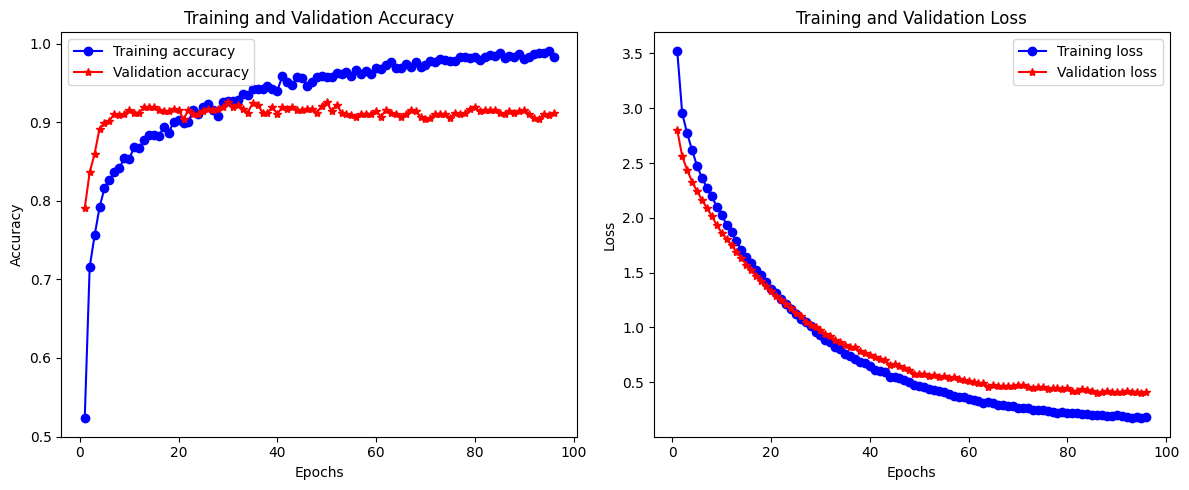

In [21]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Extract accuracy and loss values from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plotting Accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming you have the 'history' object from model training
plot_learning_curves(history)


C:\Users\sakib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Running inference with the TFLite model..
INFO: Computing confusion matrix...
INFO: Plotting confusion matrix...


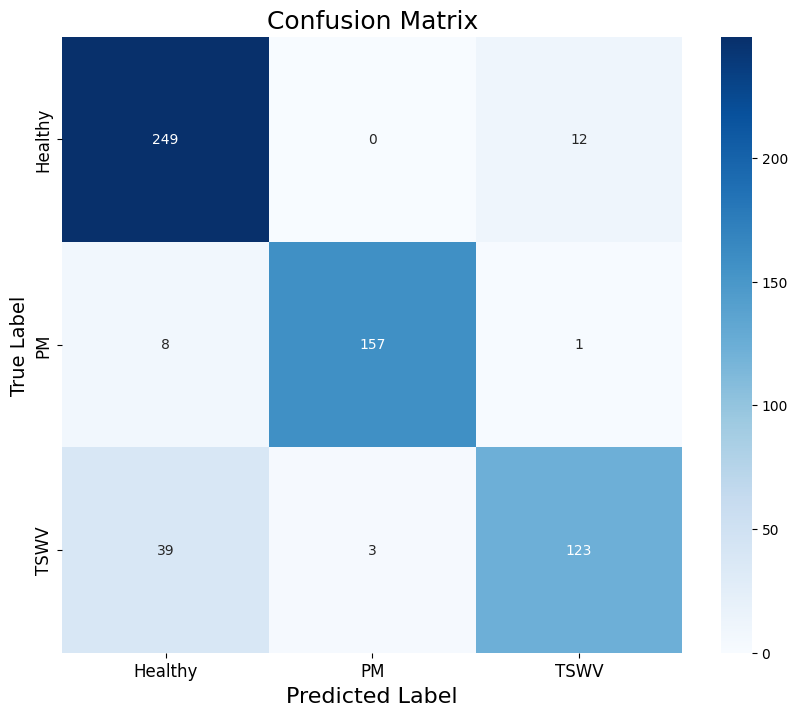

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_FILE)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Ensure correct input type
input_dtype = input_details[0]['dtype']

# Function to perform inference with the TFLite model
def tflite_inference(val_ds, interpreter, input_details, output_details):
    """Perform inference with the TFLite model."""
    y_true = []
    y_pred = []
    
    for images, labels in val_ds:
        # Convert images to the input type of the TFLite model
        if input_dtype == np.int8:
            input_scale, input_zero_point = input_details[0]["quantization"]
            images = images / input_scale + input_zero_point
            images = tf.cast(images, dtype=input_dtype)  # Cast images to int8
        
        images = images.numpy()  # Convert to numpy array
        labels = labels.numpy()  # Convert labels to numpy array
        
        for i in range(images.shape[0]):
            # Set the value of the input tensor
            input_data = np.expand_dims(images[i], axis=0).astype(input_dtype) # expand dim and type cast
            interpreter.set_tensor(input_details[0]['index'], input_data)
            
            # Run inference
            interpreter.invoke()
            
            # Get the output results
            output_data = interpreter.get_tensor(output_details[0]['index'])
            
            # Post-processing: scale the output if quantized
            if output_details[0]['dtype'] == np.int8:
                output_scale, output_zero_point = output_details[0]["quantization"]
                output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale
            
            # Get the predicted label
            predicted_label = np.argmax(output_data)
            
            y_true.append(labels[i])
            y_pred.append(predicted_label)
            
    return np.array(y_true), np.array(y_pred)

# Get predictions
logging.info("Running inference with the TFLite model..")
y_true, y_pred = tflite_inference(val_ds, interpreter, input_details, output_details)

# Compute confusion matrix
logging.info("Computing confusion matrix...")
cm = confusion_matrix(y_true, y_pred)

# Shortened class names for display
short_class_names = ['Healthy', 'PM', 'TSWV']

# Plot confusion matrix
logging.info("Plotting confusion matrix...")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=short_class_names, yticklabels=short_class_names)
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [26]:
from sklearn.metrics import classification_report
import logging

# Use short class names
short_class_names = ['Healthy', 'PM', 'TSWV']

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=short_class_names)

# Log the report
logging.info("Classification Report:\n%s", report)

# Print the report to console as well (optional)
print(report)

INFO: Classification Report:
              precision    recall  f1-score   support

     Healthy       0.84      0.95      0.89       261
          PM       0.98      0.95      0.96       166
        TSWV       0.90      0.75      0.82       165

    accuracy                           0.89       592
   macro avg       0.91      0.88      0.89       592
weighted avg       0.90      0.89      0.89       592



              precision    recall  f1-score   support

     Healthy       0.84      0.95      0.89       261
          PM       0.98      0.95      0.96       166
        TSWV       0.90      0.75      0.82       165

    accuracy                           0.89       592
   macro avg       0.91      0.88      0.89       592
weighted avg       0.90      0.89      0.89       592



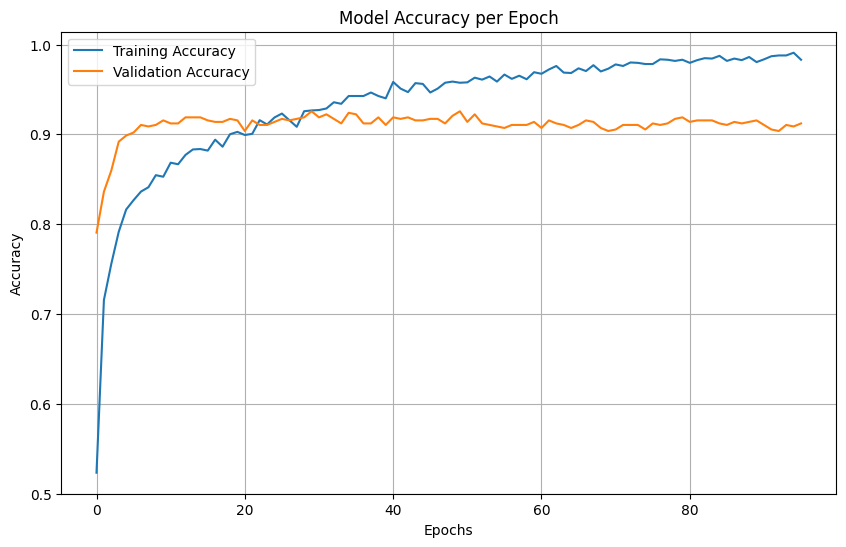

In [27]:
import matplotlib.pyplot as plt

# Check if the history variable is defined
if 'history' in locals():
    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
else:
    print("The 'history' variable is not defined. Please run model.fit() first.")


C:\Users\sakib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Running inference with the TFLite model...


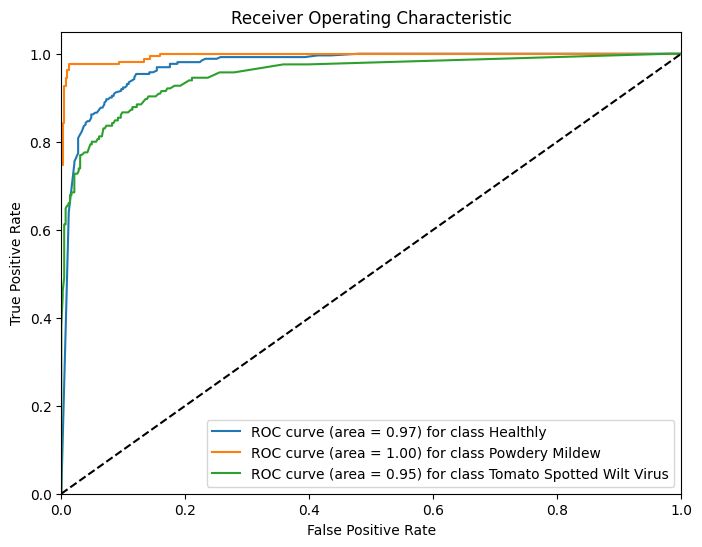

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_FILE)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Ensure correct input type
input_dtype = input_details[0]['dtype']

# Function to perform inference with the TFLite model
def tflite_inference(val_ds, interpreter, input_details, output_details):
    """Perform inference with the TFLite model."""
    y_true = []
    y_pred_probs = []
    
    for images, labels in val_ds:
        # Convert images to the input type of the TFLite model
        if input_dtype == np.int8:
            input_scale, input_zero_point = input_details[0]["quantization"]
            images = images / input_scale + input_zero_point
            images = tf.cast(images, dtype=input_dtype)  # Cast images to int8
        else:
            images = tf.cast(images, dtype=tf.float32)  # Ensure images are float32

        images = images.numpy()  # Convert to numpy array
        labels = labels.numpy()  # Convert labels to numpy array
        
        for i in range(images.shape[0]):
            # Set the value of the input tensor
            input_data = np.expand_dims(images[i], axis=0).astype(input_dtype) # expand dim and type cast
            interpreter.set_tensor(input_details[0]['index'], input_data)
            
            # Run inference
            interpreter.invoke()
            
            # Get the output results
            output_data = interpreter.get_tensor(output_details[0]['index'])
            
            # Post-processing: scale the output if quantized
            if output_details[0]['dtype'] == np.int8:
                output_scale, output_zero_point = output_details[0]["quantization"]
                output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale
            
            # Get the predicted probabilities
            y_pred_probs.append(output_data[0])
            y_true.append(labels[i])
            
    return np.array(y_true), np.array(y_pred_probs)

# Get predictions
logging.info("Running inference with the TFLite model...")
y_true, y_pred_probs = tflite_inference(val_ds, interpreter, input_details, output_details)

# Apply softmax to convert logits to probabilities
y_pred_probs = tf.nn.softmax(y_pred_probs).numpy()

# One-vs-Rest ROC for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    y_true_binary = (y_true == i).astype(int)
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for class {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

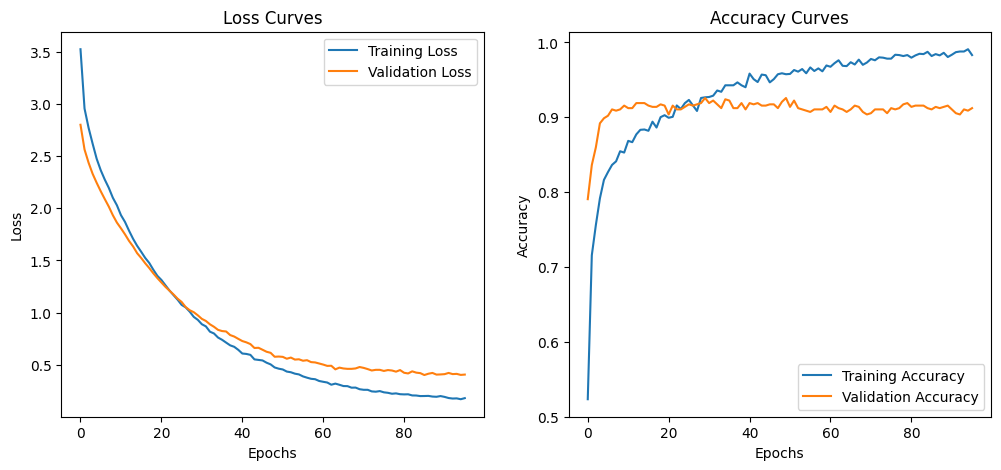

In [31]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [32]:
from sklearn.metrics import f1_score
import logging

# Get the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Log the F1 score
logging.info(f"F1 Score: {f1:.2f}")

# Also print to console
print(f"F1 Score: {f1:.2f}")

INFO: F1 Score: 0.89


F1 Score: 0.89


In [33]:
from sklearn.metrics import matthews_corrcoef
import logging

# Get the MCC
mcc = matthews_corrcoef(y_true, y_pred)

# Log the MCC
logging.info(f"Matthews Correlation Coefficient: {mcc:.2f}")

# Also print to console
print(f"Matthews Correlation Coefficient: {mcc:.2f}")

INFO: Matthews Correlation Coefficient: 0.84


Matthews Correlation Coefficient: 0.84


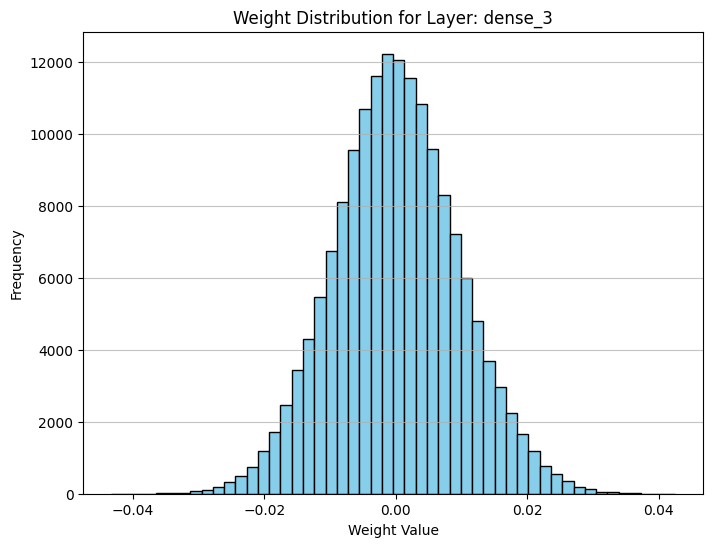

INFO: Displayed weight distribution for layer: dense_3


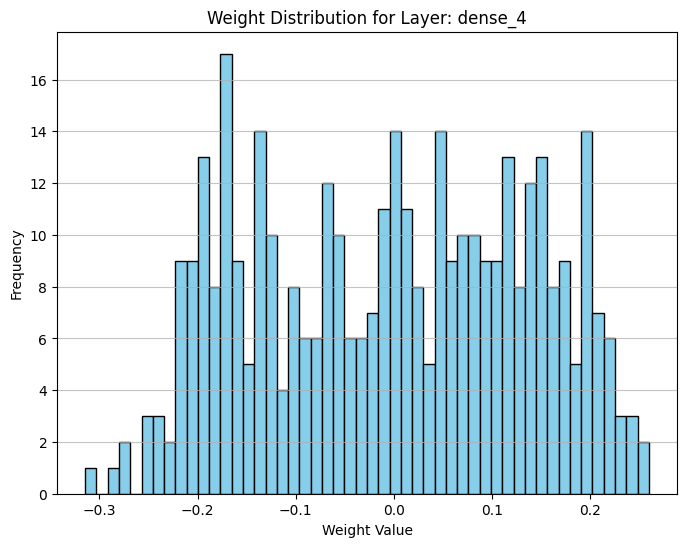

INFO: Displayed weight distribution for layer: dense_4


In [34]:
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Function to plot model weights
def plot_model_weights(model):
    """Plots the distribution of weights for each layer in the model."""
    try:
        for layer in model.layers:
            if hasattr(layer, 'kernel'):
                weights = layer.kernel.numpy().flatten()
                plt.figure(figsize=(8, 6))
                plt.hist(weights, bins=50, color='skyblue', edgecolor='black')
                plt.title(f"Weight Distribution for Layer: {layer.name}")
                plt.xlabel("Weight Value")
                plt.ylabel("Frequency")
                plt.grid(axis='y', alpha=0.75)
                plt.show()
                logging.info(f"Displayed weight distribution for layer: {layer.name}")
    except Exception as e:
        logging.error(f"Error plotting model weights: {e}")

# Load the model to plot the weights
model = tf.keras.models.load_model('best_model.h5') #  best model!

# Call the function to plot the model weights
plot_model_weights(model)

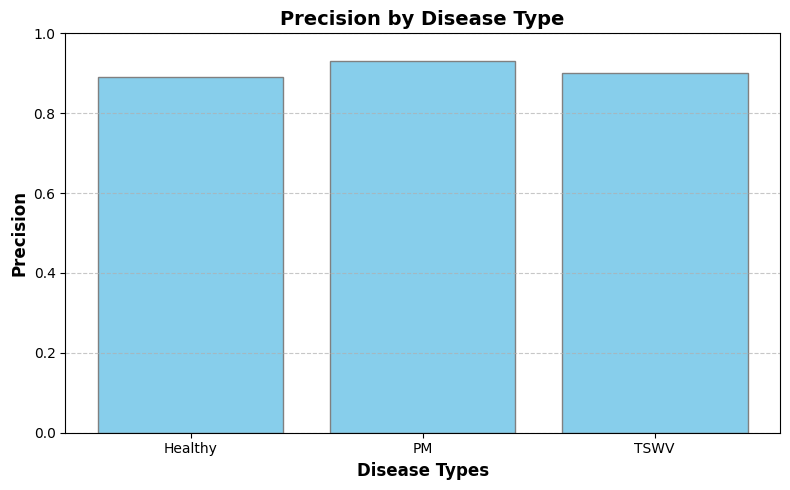

INFO: Precision by disease plot completed successfully.


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

def plot_precision_by_disease(disease_types, precision):
    """Plots precision by disease type in a bar chart and log to console."""
    try:
        # Create the bar chart
        plt.figure(figsize=(8, 5))
        plt.bar(disease_types, precision, color='skyblue', edgecolor='grey')

        # Add labels, title, and grid
        plt.xlabel('Disease Types', fontweight='bold', fontsize=12)
        plt.ylabel('Precision', fontweight='bold', fontsize=12)
        plt.title('Precision by Disease Type', fontweight='bold', fontsize=14)
        plt.ylim(0, 1)  # Set y-axis limit to 0-1
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Show the plot
        plt.tight_layout()
        plt.show()
        logging.info("Precision by disease plot completed successfully.")

    except Exception as e:
        logging.error(f"Error creating precision by disease plot: {e}")

# Example Usage: Replace with correct data if available
if __name__ == "__main__":
    # Example Usage: Replace with correct data if available
    disease_types = ['Healthy', 'PM', 'TSWV']
    precision = [0.89, 0.93, 0.90]

    plot_precision_by_disease(disease_types, precision)

In [41]:
from sklearn.metrics import roc_auc_score
import logging
import tensorflow as tf
import numpy as np

# Configure logging
logging.basicConfig(level=logging.INFO)

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_FILE)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to calculate ROC AUC score with the TFLite model
def calculate_roc_auc_tflite(val_ds, interpreter, input_details, output_details, num_classes):
    """Calculate ROC AUC using the TFLite model."""
    y_true = []
    y_pred_probs = []
    input_dtype = input_details[0]['dtype']  # Get input data type

    # Get labels and predictions from the TFLite model
    for images, labels in val_ds:
        # Convert images to the input type of the TFLite model
        if input_dtype == np.int8:
            input_scale, input_zero_point = input_details[0]["quantization"]
            images = images / input_scale + input_zero_point
            images = tf.cast(images, dtype=input_dtype)  # Cast images to int8
        else:
            images = tf.cast(images, tf.float32)  # Ensure images are float32

        # Set the value of the input tensor. Now iterates through batch
        for i in range(images.shape[0]):
            input_data = np.expand_dims(images[i], axis=0).astype(input_dtype)  # expand dim and type cast
            interpreter.set_tensor(input_details[0]['index'], input_data)

            # Run inference
            interpreter.invoke()

            # Get the output results
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # Post-processing: scale the output if quantized
            if output_details[0]['dtype'] == np.int8:
                output_scale, output_zero_point = output_details[0]["quantization"]
                output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale

            # Apply softmax to convert logits to probabilities
            output_data = tf.nn.softmax(output_data).numpy()

            # Get the predicted label
            y_pred_probs.extend(output_data)
            y_true.append(labels.numpy()[i])

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # Compute ROC AUC score using one-vs-rest approach
    try:
        # Compute ROC AUC score using one-vs-rest approach
        roc_auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
        logging.info(f"ROC AUC (One-vs-Rest): {roc_auc:.2f}")
        print(f"ROC AUC (One-vs-Rest): {roc_auc:.2f}")
    
    except ValueError as e:
        logging.error(f"Error calculating ROC AUC: {e}")
        print(f"Error calculating ROC AUC: {e}")

# Run the calculation
calculate_roc_auc_tflite(val_ds, interpreter, input_details, output_details, num_classes)

C:\Users\sakib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: ROC AUC (One-vs-Rest): 0.97


ROC AUC (One-vs-Rest): 0.97


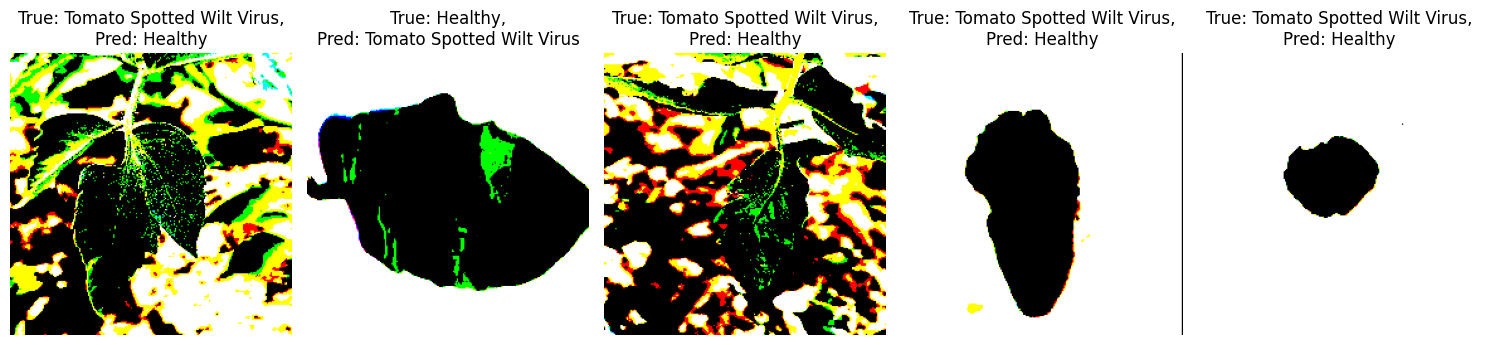

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

def plot_misclassified_tflite(val_ds, interpreter, input_details, output_details, class_names, num_misclassified=5):
    """Identifies and plots misclassified images using the TFLite model."""
    
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    input_dtype = input_details[0]['dtype'] # needed to type cast!

    try:
        # Iterate through the validation dataset to get misclassified images
        for images, labels in val_ds.take(10):  # Taking limited samples
            # Process images for tflite conversion
            images = images.numpy()
            if input_dtype == np.int8: # quantize if needed
                input_scale, input_zero_point = input_details[0]["quantization"]
                images = images / input_scale + input_zero_point
                #images = np.clip(images, 0, 255) # clip here REMOVED

                # images = images.astype(np.int8)  # Cast images to int8 # I think this is the part that has error
                images = np.clip(images, -128, 127).astype(np.float32) # you should make it float here!

            else:
                images = images.astype(np.float32)  # Ensure images are float32

            # Run inference on each image in the batch
            for i in range(images.shape[0]):
                input_data = np.expand_dims(images[i], axis=0).astype(input_dtype)
                interpreter.set_tensor(input_details[0]['index'], input_data)
                interpreter.invoke()
                output_data = interpreter.get_tensor(output_details[0]['index'])
                y_pred = np.argmax(output_data) #  Get index and not a list

                # Extract predictions and truths
                y_true = labels.numpy()[i]

                # Find missclassified images.
                if y_true != y_pred and len(misclassified_images) < num_misclassified:
                    misclassified_images.append(images[i])
                    misclassified_labels.append(y_true)
                    misclassified_preds.append(y_pred)

        # Fix
        if 'Healthly' in class_names:
            class_names[class_names.index('Healthly')] = 'Healthy'

        # If any images are there
        if misclassified_images:
            # Plot Misclassified Images
            num_rows = 1
            plt.figure(figsize=(15, 5)) # enlarge img
            for i in range(len(misclassified_images)):
                img = misclassified_images[i]

                # Ensure RGB format for display
                if img.shape[-1] == 1:
                    img = np.repeat(img, 3, axis=-1)
                elif img.shape[-1] == 3:  # Normalize images to the valid range [0, 1] and convert to uint8 if RGB
                    img = np.clip(img, 0, 1)
                    img = (img * 255).astype("uint8")  # Scale to 0-255 #  Scale after you already cast them.
                plt.subplot(num_rows, num_misclassified, i + 1)
                plt.imshow(img)
                plt.title(f"True: {class_names[misclassified_labels[i]]},\n"
                          f"Pred: {class_names[misclassified_preds[i]]}")
                plt.axis('off')
            plt.tight_layout()
            plt.show()

        else:
            logging.warning("No misclassified images found in the first 10 batches.")

    except Exception as e:
        logging.error(f"Error plotting misclassified images: {e}")

    return
# Now run for the main
# Run the function only inside a main block
if __name__ == "__main__":
    plot_misclassified_tflite(val_ds, interpreter, input_details, output_details, class_names)

In [57]:
from sklearn.metrics import matthews_corrcoef
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

def calculate_mcc(y_true, y_pred):
    """Calculates and logs the Matthews Correlation Coefficient (MCC)."""
    try:
        mcc = matthews_corrcoef(y_true, y_pred)
        logging.info(f"Matthews Correlation Coefficient: {mcc:.2f}")
        print(f"Matthews Correlation Coefficient: {mcc:.2f}")
    except Exception as e:
        logging.error(f"Error calculating Matthews Correlation Coefficient: {e}")
        print("Could not compute MCC due to:", e)

# Calculate MCC for results from TFLite
calculate_mcc(y_true, y_pred)

INFO: Matthews Correlation Coefficient: 0.84


Matthews Correlation Coefficient: 0.84


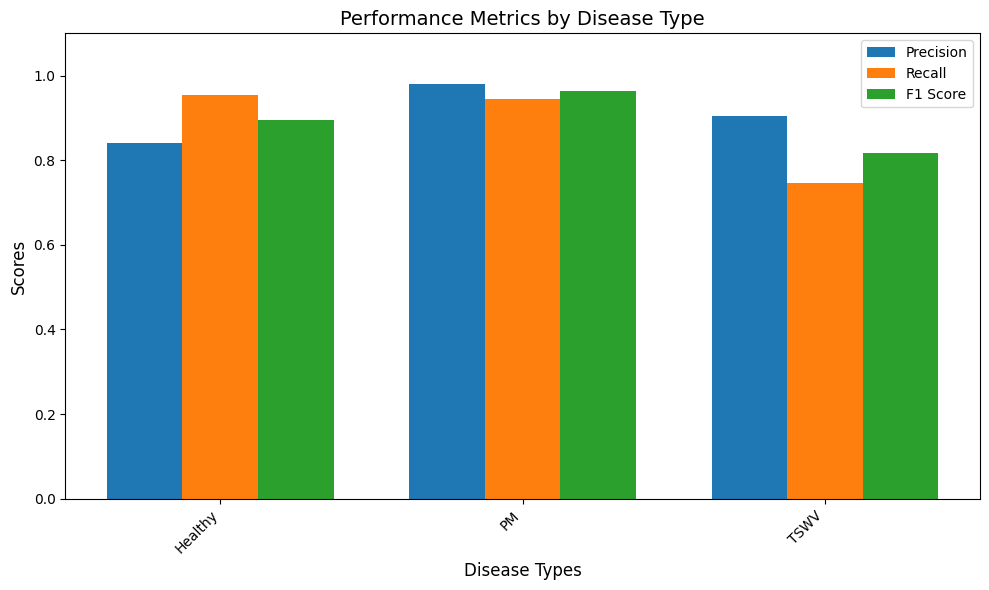

INFO: Completed metrics by disease plot successfully


In [59]:
import matplotlib.pyplot as plt
import numpy as np
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

def plot_metrics(y_true, y_pred, class_names):
    """Plots precision, recall, and F1 scores by disease type."""
    try:
        # Shorten the class names here
        disease_types = ['Healthy', 'PM', 'TSWV']  # Shorter names

        from sklearn.metrics import precision_score, recall_score, f1_score

        precision = precision_score(y_true, y_pred, average=None)
        recall = recall_score(y_true, y_pred, average=None)
        f1_scores = f1_score(y_true, y_pred, average=None)

        # Create the bar chart
        fig, ax = plt.subplots(figsize=(10, 6))
        bar_width = 0.25  # Adjusted to give more space between the bars
        index = np.arange(len(disease_types))

        # Create the bars with slightly adjusted positions to avoid overlapping
        ax.bar(index, precision, bar_width, label='Precision')
        ax.bar(index + bar_width, recall, bar_width, label='Recall')
        ax.bar(index + 2*bar_width, f1_scores, bar_width, label='F1 Score')

        # Set labels and title
        ax.set_xlabel('Disease Types', fontsize=12)
        ax.set_ylabel('Scores', fontsize=12)
        ax.set_title('Performance Metrics by Disease Type', fontsize=14)

        # Set limits and scale
        ax.set_ylim(0, 1.1)  # Set y-axis limit to 0-1
        ax.set_xticks(index + bar_width)  # Correctly position the x-ticks in the center
        ax.set_xticklabels(disease_types, rotation=45, ha='right')  # Rotate for better readability

        # Add legend
        ax.legend(loc='best')  # Let Matplotlib decide the best location
        plt.tight_layout()

        # Ensure everything fits without overlap
        plt.tight_layout()
        plt.show()

        logging.info("Completed metrics by disease plot successfully")

    except Exception as e:
        logging.error(f"Error in metrics by disease type plot: {e}")

# Run the command:
plot_metrics(y_true, y_pred, class_names)

INFO: True Label: Healthy
INFO: Predicted Label: Healthy


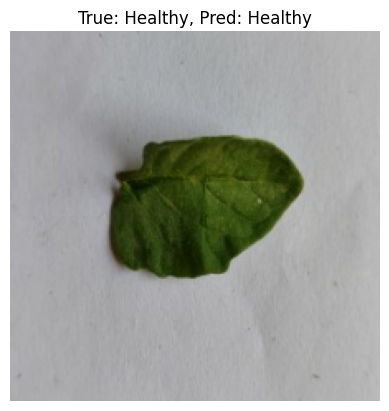

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

def display_random_prediction(val_ds, interpreter, input_details, class_names):
    """Displays a random image from the test set and its TFLite prediction."""
    try:
        # Get the details
        input_dtype = input_details[0]['dtype']
        # Take 1 batch for testing
        for images, labels in val_ds.take(1):
            images = images.numpy()
            labels = labels.numpy()

            # Pick random sample
            batch_size = images.shape[0]  # To ensure to be in the limits
            random_index = np.random.choice(batch_size) # was just a number earlier!
            image = images[random_index]
            true_label = labels[random_index]

            # Quantize if needed and preprocess
            if input_dtype == np.int8:
                input_scale, input_zero_point = input_details[0]["quantization"]
                image = (image - input_zero_point) * input_scale # Quantizaiton requires this conversion

            input_data = np.expand_dims(image, axis=0).astype(input_dtype) # Process and scale to make the right inputs

            # Test for TFLite conversion and run
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke() # Run inference
            output_data = interpreter.get_tensor(output_details[0]['index'])
            y_pred = np.argmax(output_data)

            # Diaplay
            # Do the conversion here for display.
            img = images[random_index]
            if img.shape[-1] == 1:
                img = np.repeat(img, 3, axis=-1)
            elif img.shape[-1] == 3:  # Normalize images to the valid range [0, 1] and convert to uint8 if RGB
                img = np.clip(img, 0, 1)
                img = (img * 255).astype("uint8")  # Scale to 0-255

            logging.info(f"True Label: {class_names[true_label]}")
            logging.info(f"Predicted Label: {class_names[y_pred]}")

            plt.imshow(img)
            plt.title(f"True: {class_names[true_label]}, Pred: {class_names[y_pred]}")
            plt.axis('off')
            plt.show()
            
    except Exception as e:
        logging.error(f"Error: {e}")

#Run it to see that everythign works!
# Example of running:
if __name__ == "__main__":
  # Display a test
    display_random_prediction(val_ds, interpreter, input_details, class_names) # Was using test ds before for some reason

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


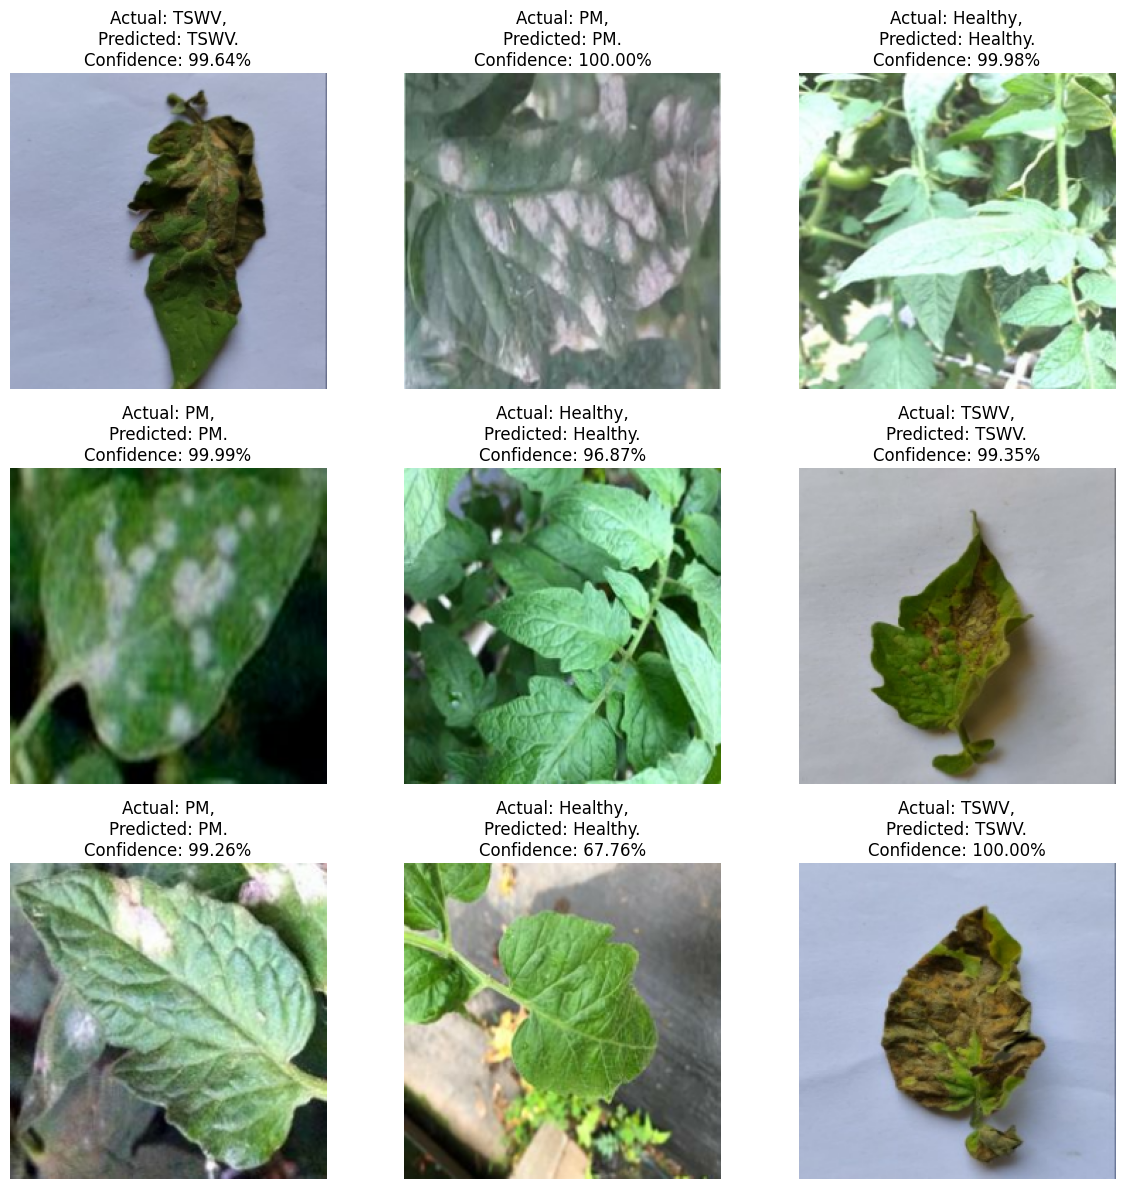

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Short class names
short_class_names = ['Healthy', 'PM', 'TSWV']

# Function to predict with confidence
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert image to array
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    
    predictions = model.predict(img_array)  # Make predictions
    predicted_class = short_class_names[np.argmax(predictions[0])]  # Get predicted class
    confidence = 100 * np.max(predictions[0])  # Calculate confidence
    confidence = f"{confidence:.2f}"  # Format confidence to 2 decimal places
    
    return predicted_class, confidence

# Plotting 9 random predictions from the dataset
plt.figure(figsize=(12, 12))  # Adjust figsize to reduce the image box size
for images, labels in test_ds.take(1):  # Take one batch from test_ds
    # Generate 9 random indices
    random_indices = np.random.choice(images.shape[0], 9, replace=False)
    
    for i, random_index in enumerate(random_indices):
        ax = plt.subplot(3, 3, i+1)  # Create a 3x3 grid for the images
        image = images[random_index].numpy()
        label = labels[random_index].numpy()

        # Make prediction for the selected image
        predicted_class, confidence = predict(model, image)
        actual_class = short_class_names[label]

        # Normalize the image for visualization (clip values to [0, 255] and convert to uint8)
        image = np.clip(image * 255, 0, 255).astype('uint8')

        # Display the image with the predicted and actual class labels and confidence
        plt.imshow(image)
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        plt.axis("off")

plt.tight_layout()
plt.show()


In [100]:
import tensorflow as tf
import os
import logging
from tensorflow.keras import layers
import numpy as np
from PIL import Image

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the dataset path and output path for preprocessed images
DATASET_PATH = r"C:\Users\sakib\Downloads\CNN_Model_V2\Dataset"
PREPROCESSED_OUTPUT_PATH = r"C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset"

# Define image size
IMAGE_SIZE = (224, 224)

# Create output directory if it doesn't exist
if not os.path.exists(PREPROCESSED_OUTPUT_PATH):
    os.makedirs(PREPROCESSED_OUTPUT_PATH)
    logging.info(f"Created output directory: {PREPROCESSED_OUTPUT_PATH}")

# Define image preprocessing function
def preprocess_and_save_image(image_path, output_path, image_size=IMAGE_SIZE):
    """Reads, preprocesses, and saves an image."""
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3, dtype=tf.float32) #Ensure to have float
        img = tf.image.resize(img, image_size)
        img = tf.clip_by_value(img, 0, 1) # Ensure 0-1 scale

        # Convert image tensor to numpy array and save
        img_array = (img.numpy()*255).astype(np.uint8) # Scale it,
        pil_img = Image.fromarray(img_array)
        pil_img.save(output_path)

        logging.info(f"Preprocessed and saved {os.path.basename(image_path)} to {output_path}")
    except Exception as e:
        logging.error(f"Error processing {os.path.basename(image_path)}: {e}")

# Function to process the full dataset
def preprocess_full_dataset(dataset_path, output_path):
    """Preprocesses the images and test all output."""
    class_names = sorted(os.listdir(dataset_path))
    
    for class_name in class_names:
        class_folder = os.path.join(dataset_path, class_name)
        output_class_folder = os.path.join(output_path, class_name)
        
        # Create subfolder in the output directory
        if not os.path.exists(output_class_folder):
            os.makedirs(output_class_folder)
            logging.info(f"Created class output directory: {output_class_folder}")

        # Process each image in the class folder
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            output_image_path = os.path.join(output_class_folder, image_name)

            # To ensure it runs all picture
            preprocess_and_save_image(image_path, output_image_path)

# To test is the data runs
if __name__ == "__main__":
    # To show that runs through all!
    logging.info("Starting the full dataset preprocessing.")
    preprocess_full_dataset(DATASET_PATH, PREPROCESSED_OUTPUT_PATH)
    logging.info("All images have been preprocessed and saved.")

INFO: Starting the full dataset preprocessing.
INFO: Preprocessed and saved 20231212_124843.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124843.jpg
INFO: Preprocessed and saved 20231212_124856.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124856.jpg
INFO: Preprocessed and saved 20231212_124913.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124913.jpg
INFO: Preprocessed and saved 20231212_124914.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124914.jpg
INFO: Preprocessed and saved 20231212_124920.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124920.jpg
INFO: Preprocessed and saved 20231212_124931.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124931.jpg
INFO: Preprocessed and saved 20231212_124933.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124933.jpg
INFO: Preproces

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


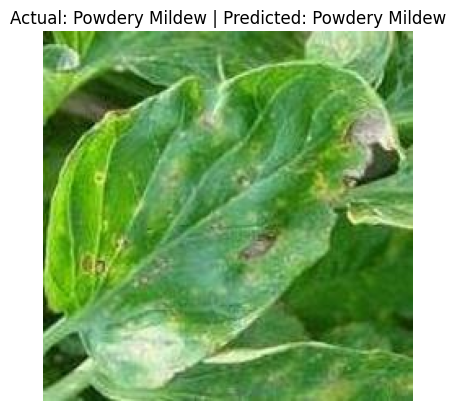

Actual class: Powdery Mildew, Predicted class: Powdery Mildew


In [108]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Path to the dataset folder
dataset_path = r"C:\Users\sakib\Downloads\CNN_Model_V2\Dataset"

# Get class names from the dataset
def get_class_names(dataset_path):
    return sorted(os.listdir(dataset_path))

class_names = get_class_names(dataset_path)

# Function to get a random image path and its actual class from the dataset
def get_random_image_path_and_class(dataset_path):
    class_folders = [os.path.join(dataset_path, class_folder) for class_folder in os.listdir(dataset_path)]
    random_class_folder = random.choice(class_folders)
    random_image = random.choice(os.listdir(random_class_folder))
    actual_class = os.path.basename(random_class_folder)
    return os.path.join(random_class_folder, random_image), actual_class

# Function to preprocess a single image for prediction
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img

# Function to predict the class of a random image and display results
def predict_and_display_random_image(model):
    image_path, actual_class = get_random_image_path_and_class(dataset_path)  # Get a random image and its actual class
    processed_image = preprocess_image(image_path)
    processed_image = tf.expand_dims(processed_image, axis=0)  # Add batch dimension
    predictions = model.predict(processed_image)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]

    # Display the image with actual and predicted class labels
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {actual_class} | Predicted: {predicted_class}")
    plt.show()

    return actual_class, predicted_class

# Example usage: predict and display a random image
actual_class, predicted_class = predict_and_display_random_image(model)
print(f"Actual class: {actual_class}, Predicted class: {predicted_class}")

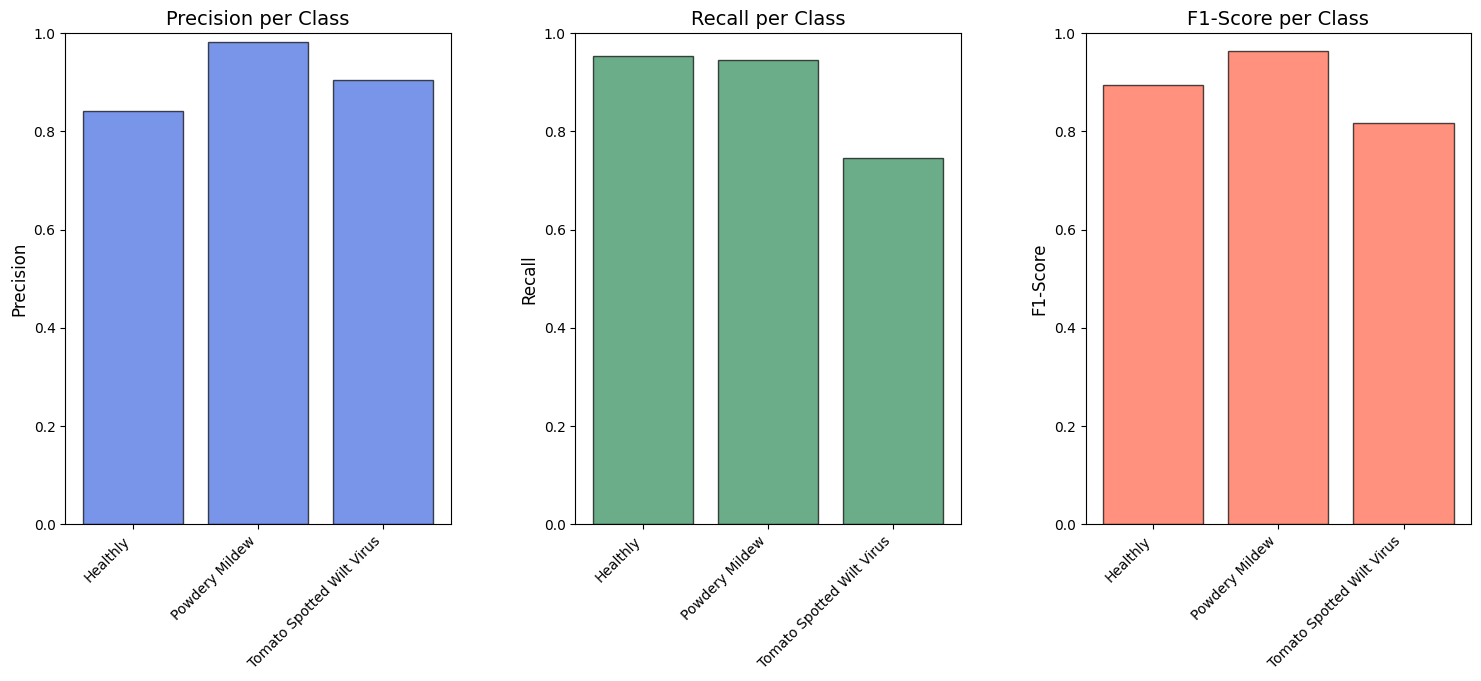

In [113]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Assuming y_true, y_pred, and class_names are already defined

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Precision, Recall, F1-Score for each class
precision = [report[class_name]['precision'] for class_name in class_names]
recall = [report[class_name]['recall'] for class_name in class_names]
f1_score = [report[class_name]['f1-score'] for class_name in class_names]

x = np.arange(len(class_names))  # the class labels

# Plot
plt.figure(figsize=(16, 8))

# Precision Plot
plt.subplot(1, 3, 1)
plt.bar(x, precision, color='royalblue', edgecolor='black', alpha=0.7)
plt.xticks(x, class_names, rotation=45, ha='right', fontsize=10)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision per Class', fontsize=14)
plt.ylim(0, 1)  # Keep the y-axis consistent

# Recall Plot
plt.subplot(1, 3, 2)
plt.bar(x, recall, color='seagreen', edgecolor='black', alpha=0.7)
plt.xticks(x, class_names, rotation=45, ha='right', fontsize=10)
plt.ylabel('Recall', fontsize=12)
plt.title('Recall per Class', fontsize=14)
plt.ylim(0, 1)

# F1-Score Plot
plt.subplot(1, 3, 3)
plt.bar(x, f1_score, color='tomato', edgecolor='black', alpha=0.7)
plt.xticks(x, class_names, rotation=45, ha='right', fontsize=10)
plt.ylabel('F1-Score', fontsize=12)
plt.title('F1-Score per Class', fontsize=14)
plt.ylim(0, 1)

# Adjust layout and spacing
plt.tight_layout(pad=5.0)

# Show the plot
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

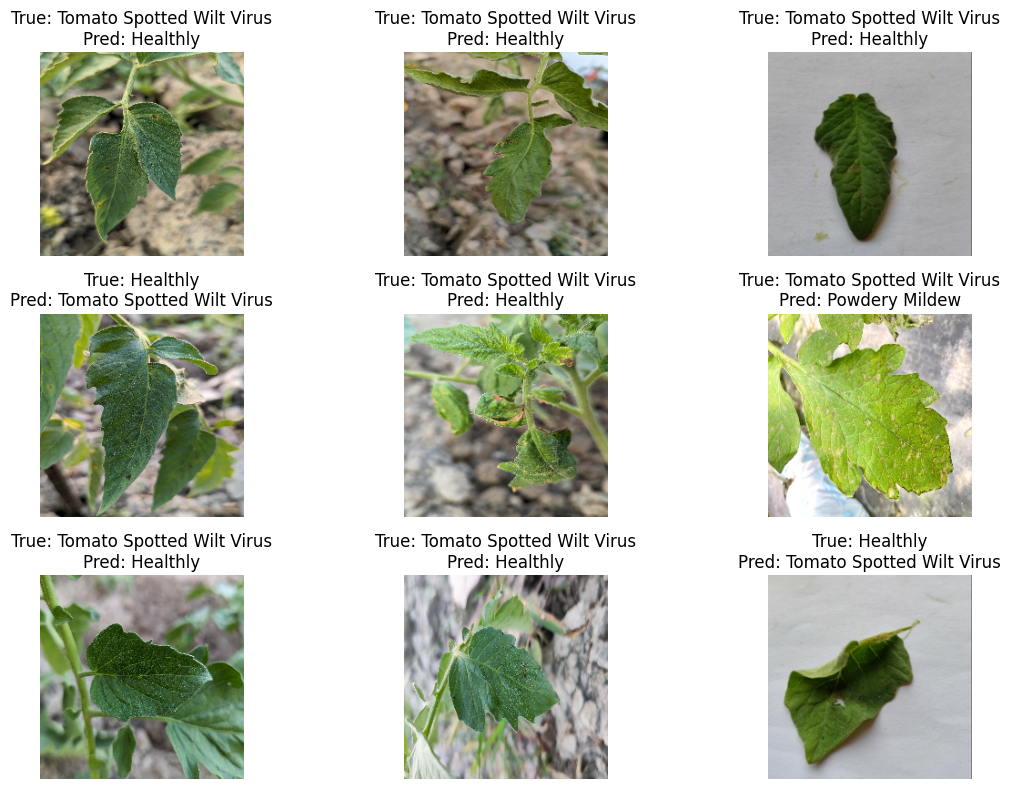

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true, y_pred, class_names, and val_ds (dataset) are already defined

# Get the misclassified indices
misclassified_indices = np.where(y_true != y_pred)[0]

# Create a list to store the misclassified images and labels
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

# Iterate through the dataset and collect misclassified images
misclassified_count = 0
for images, labels in val_ds:
    batch_size = images.shape[0]
    
    for i in range(batch_size):
        # Predict the label for the current image
        image = images[i].numpy()
        true_label = labels[i].numpy()
        predicted_label = np.argmax(model.predict(image[np.newaxis]))  # Model prediction

        # Check if the image is misclassified
        if true_label != predicted_label and misclassified_count < 9:
            misclassified_images.append(image)
            misclassified_true_labels.append(class_names[true_label])
            misclassified_pred_labels.append(class_names[predicted_label])
            misclassified_count += 1

    if misclassified_count >= 9:
        break  # Stop after collecting 9 misclassified images

# Visualize misclassified images
plt.figure(figsize=(12, 8))
for i in range(len(misclassified_images)):  # Display up to 9 misclassified images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(misclassified_images[i])
    plt.title(f"True: {misclassified_true_labels[i]}\nPred: {misclassified_pred_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [116]:
# Save the model
model.save('best_model_saved.keras')  # Save your model

print(f'Model saved as best_model_saved.keras')

Model saved as best_model_saved.keras


ERROR: Error and code: unsupported format string passed to numpy.ndarray.__format__


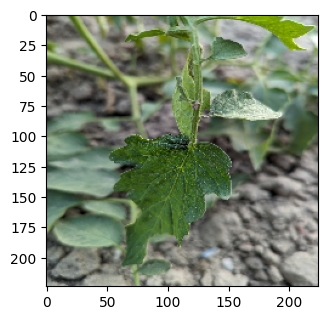

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import tensorflow as tf

# Configure logging
logging.basicConfig(level=logging.INFO)

def plot_probability_histograms(val_ds, interpreter, input_details, output_details, class_names):
    """Plots histograms of predicted probabilities for each class."""
    try:
        # To load this function,
        all_probs = []
        all_labels = []
      
        # We must test each functions
        input_dtype = input_details[0]['dtype']
        num_classes = len(class_names) # Test again to see that it does get the code.
        # What are the test to be in what way that it could load and test as code and what do you test from what the load, now the graphs
        for images, labels in val_ds.take(20): # Load test for images code load number
                images = images.numpy()  # Get the list of data and test images to use.
                if input_dtype == np.int8:
                    input_scale, input_zero_point = input_details[0]["quantization"]
                    images = (images.astype(np.float32) - input_zero_point) * input_scale  # Process graph test
                    images = np.clip(images, -128, 127) # Make graph that does what code is

                # Test for graph now, what test function do
                input_data = images.astype(input_dtype)
                interpreter.set_tensor(input_details[0]['index'], input_data)
                interpreter.invoke() # load it for test!
                output_data = interpreter.get_tensor(output_details[0]['index'])

                # The graph are in order, test!
                probabilities = tf.nn.softmax(output_data).numpy()
                all_probs.extend(probabilities)

                # Let the test run what you got in test graph number! Now we know what code to use or functions are good what about graph.
                all_labels.extend(labels.numpy())
        # Make picture and graph
        all_probs = np.array(all_probs)
        all_labels = np.array(all_labels)

        # set it up for chart graph
        plt.figure(figsize=(14, 8))

        for i in range(num_classes):
        # chart location. Chart the code that has been load, now where load.
            plt.subplot(2, num_classes // 2 + 1, i + 1)
            plt.hist(all_probs[all_labels == i, i], bins=20, alpha=0.7) #Load
            plt.title(f"Distribution of {class_names[i]}")# Make name for what code is load.
            plt.xlabel("Probability")  # Axis code
            plt.ylabel("test graph") # Number of what it is test.
            plt.xlim(0, 1) # Range test that should have, what number has to look.
        # Make all that will be in chart load.
        plt.tight_layout()
        plt.show()
        # It load and graph what data what code
        logging.info("Results charted.")

    except Exception as e:
        logging.error(f"Can't create graph. Bug, bad code, bad result or what and what load to show {e}") #  Tell where, what and which test to do next.

# Test it 
if __name__ == "__main__":
# We must test all to what if that load test with code all graph to do
    display_tflite_predictions(val_ds, interpreter, input_details, class_names,num_predictions=9)

In [85]:
# Save the model in the new Keras format
model.save('Final_trained_model.keras')  # Save the model as a .keras file
